In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_identity.csv', 'test_identity.csv', 'test_transaction.csv', 'sample_submission.csv', 'train_transaction.csv']


# Foreword:
This is a really lazy but effective and easy-to-understand method to see how features affect targeted labels' distributions. It's also widely applicable to other competitions / real-life problems

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_identity = pd.read_csv('../input/train_identity.csv')
train_transaction = pd.read_csv('../input/train_transaction.csv')
test_identity = pd.read_csv('../input/test_identity.csv')
test_transaction = pd.read_csv('../input/test_transaction.csv')

In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Add isFraud value to test data, value 2 means 'unknown'

In [5]:
test_transaction['isFraud'] = 2

# EDA Transaction Dataset

In [6]:
transaction = pd.concat([train_transaction,test_transaction],axis=0)
print (transaction.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(1097231, 394)


## For Object features, I use barplot to see the distribution

In [7]:
def eda_object(df,feature):
    a = len(df[feature].unique())
    plt.figure(figsize = [20,min(max(8,a),12)])

    plt.subplot(1,3,1)
    x_ = df.groupby([feature])[feature].count()
    x_.plot(kind='pie')
    plt.title(feature)

    plt.subplot(1,3,2)
    cross_tab = pd.crosstab(df['isFraud'],df[feature],normalize=0).reset_index()
    x_ = cross_tab.melt(id_vars=['isFraud'])
    x_['value'] = x_['value']*100

    sns.barplot(x=feature,y='value',hue ='isFraud',data=x_,palette = ['b','r','g'],alpha =0.7)
    plt.xticks(rotation='vertical')
    plt.title(feature + " - Normalized by isFraud")

    plt.subplot(1,3,3)
    cross_tab = pd.crosstab(df[feature],df['isFraud'],normalize=1).reset_index()
    cross_tab['Difference'] = cross_tab[0] - cross_tab[1]
    cross_tab['Difference'] = cross_tab['Difference']*100

    sns.barplot(x=feature,y='Difference',data=cross_tab,alpha =0.7)
    plt.ylim(-100,100)
    plt.xticks(rotation='vertical')
    plt.title(feature + " - Difference")

    plt.tight_layout()
    plt.legend()
    plt.show()
       

To save space, I just draw 10 available features

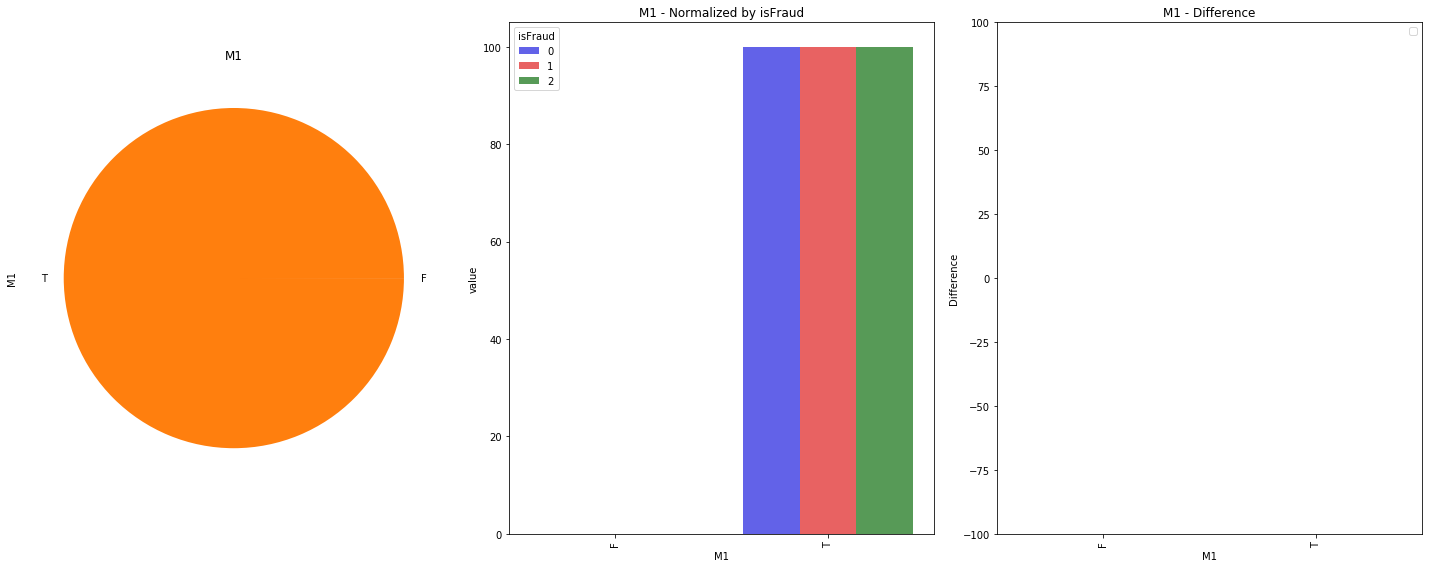

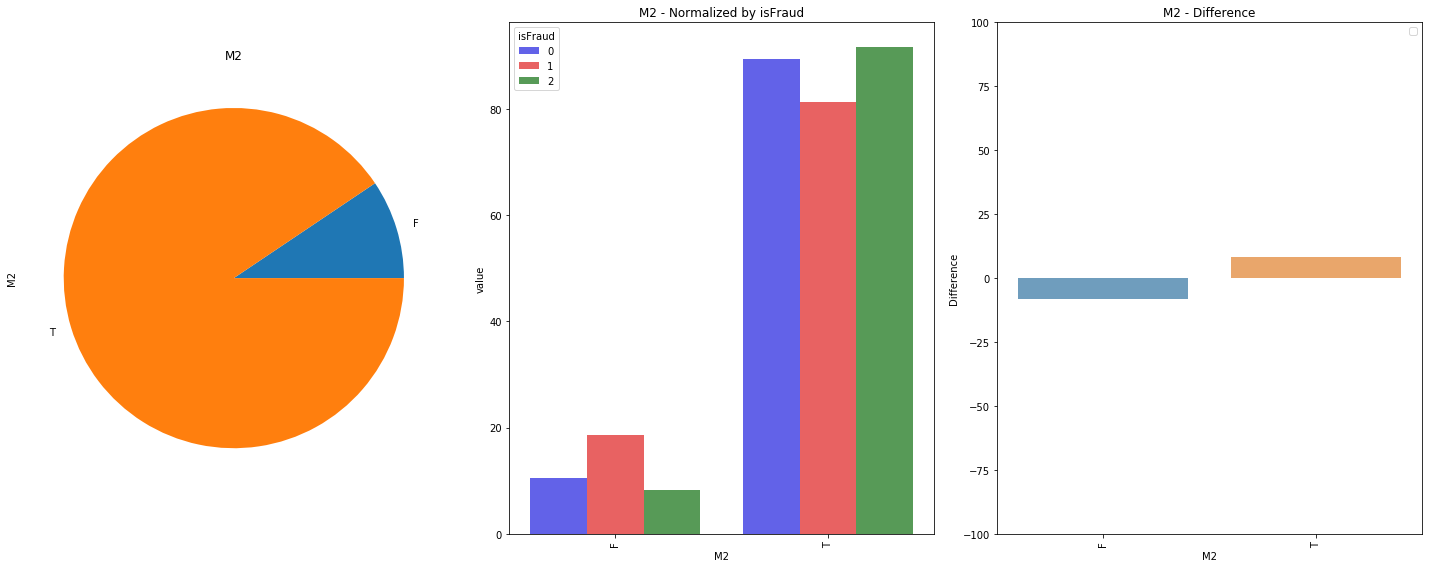

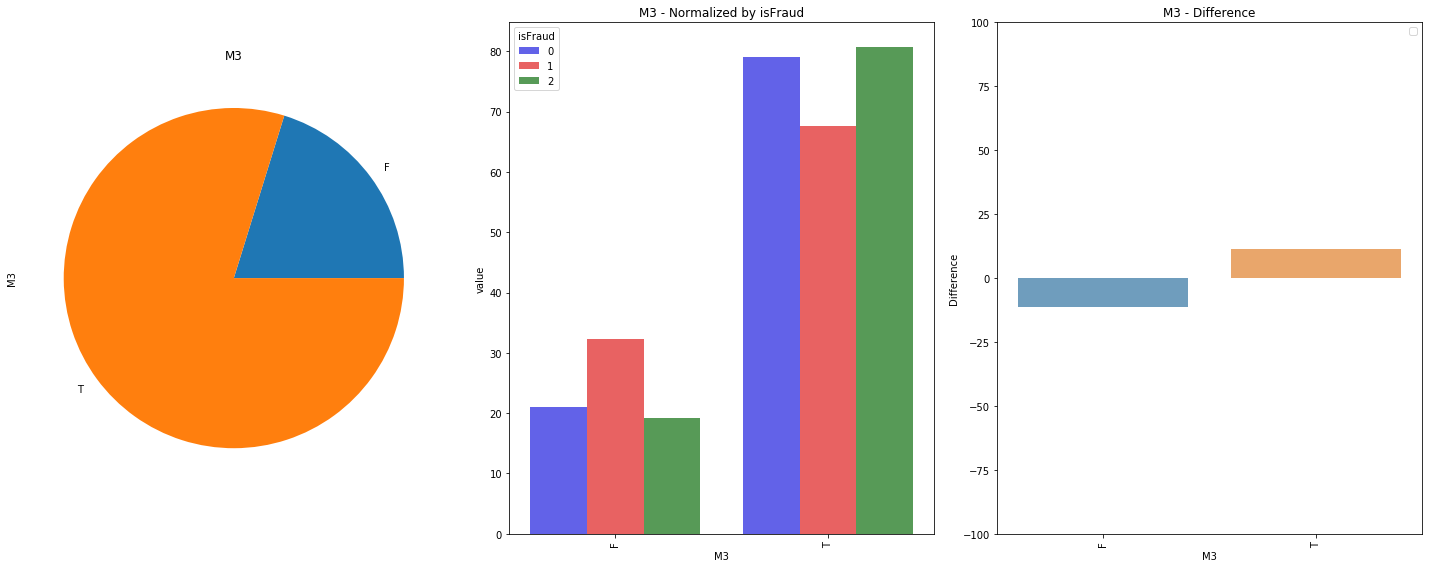

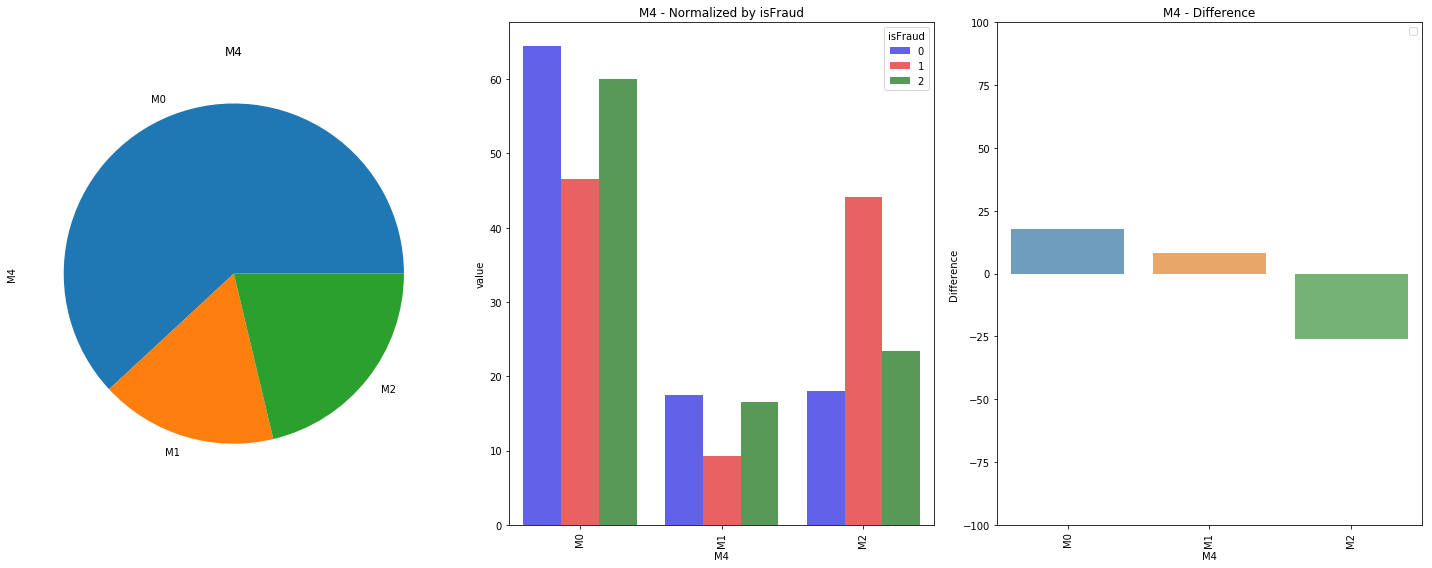

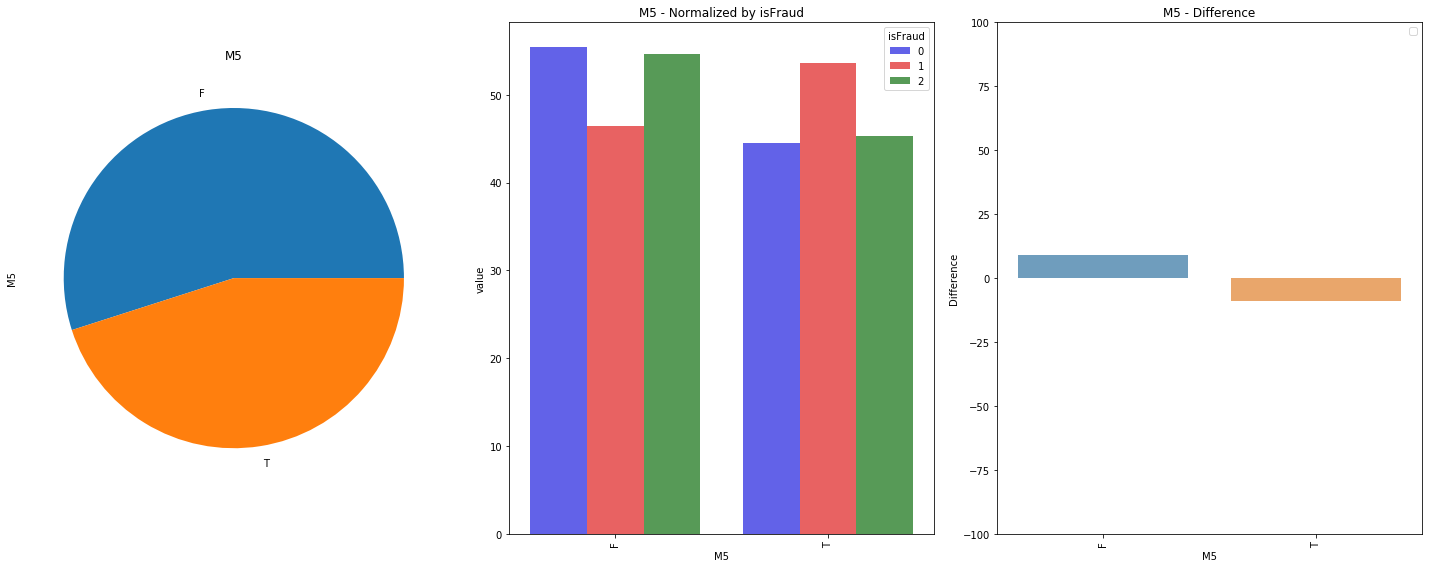

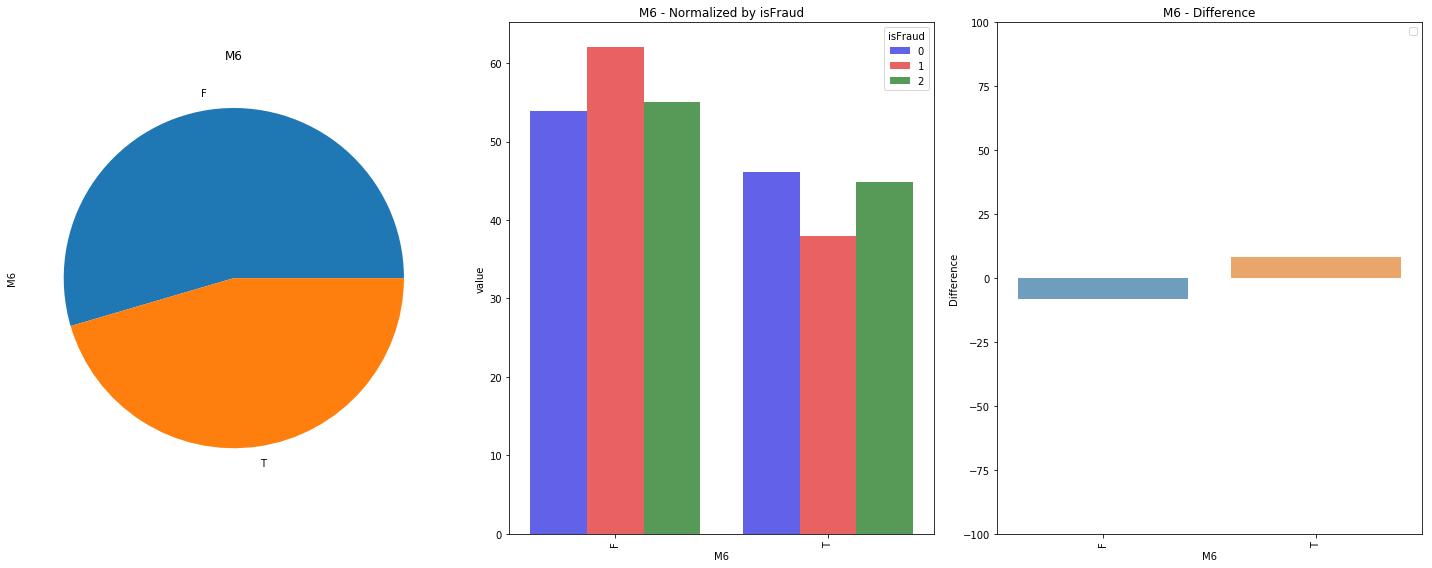

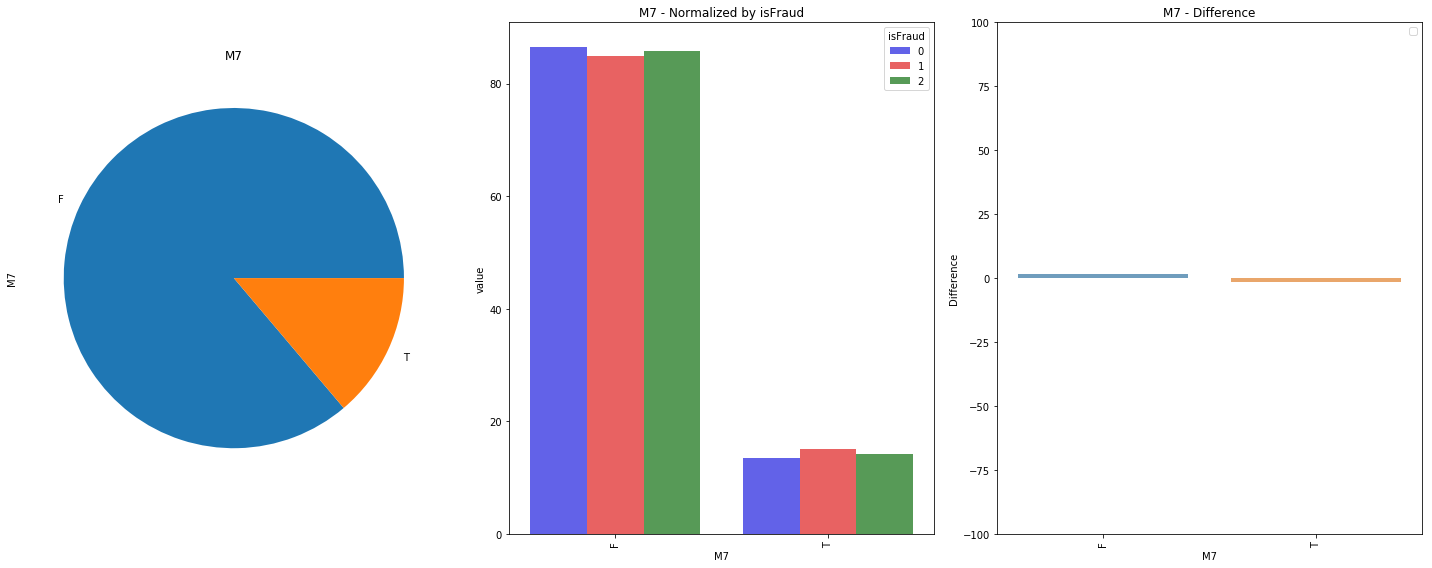

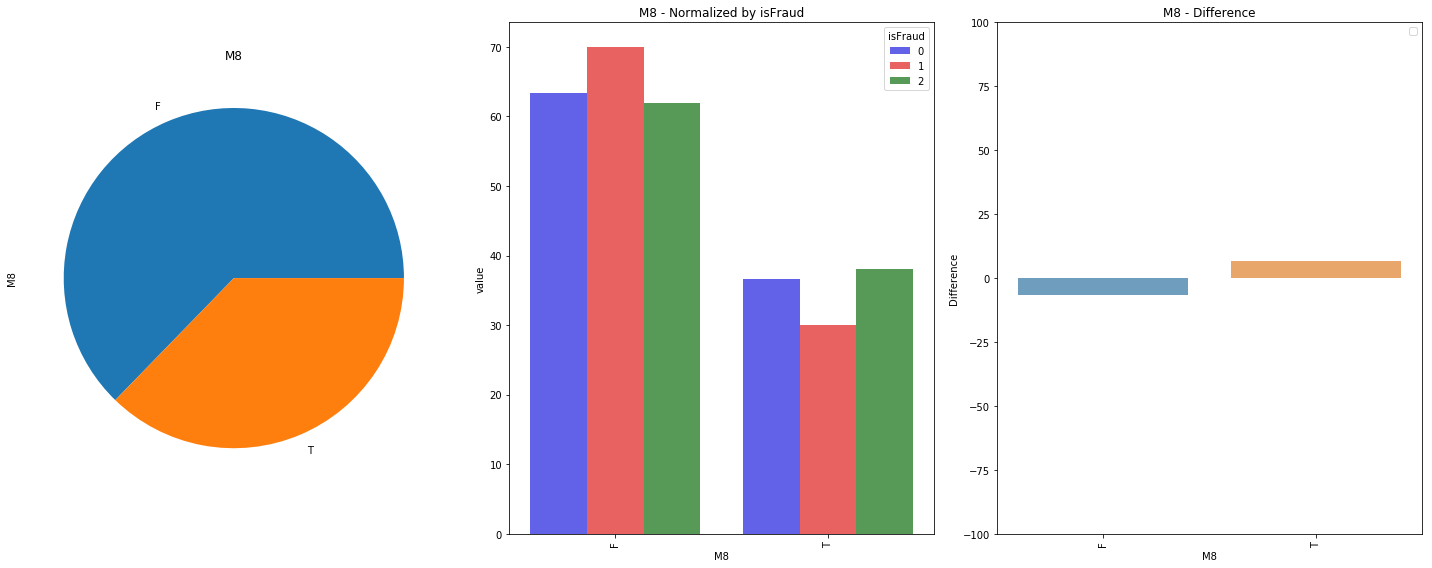

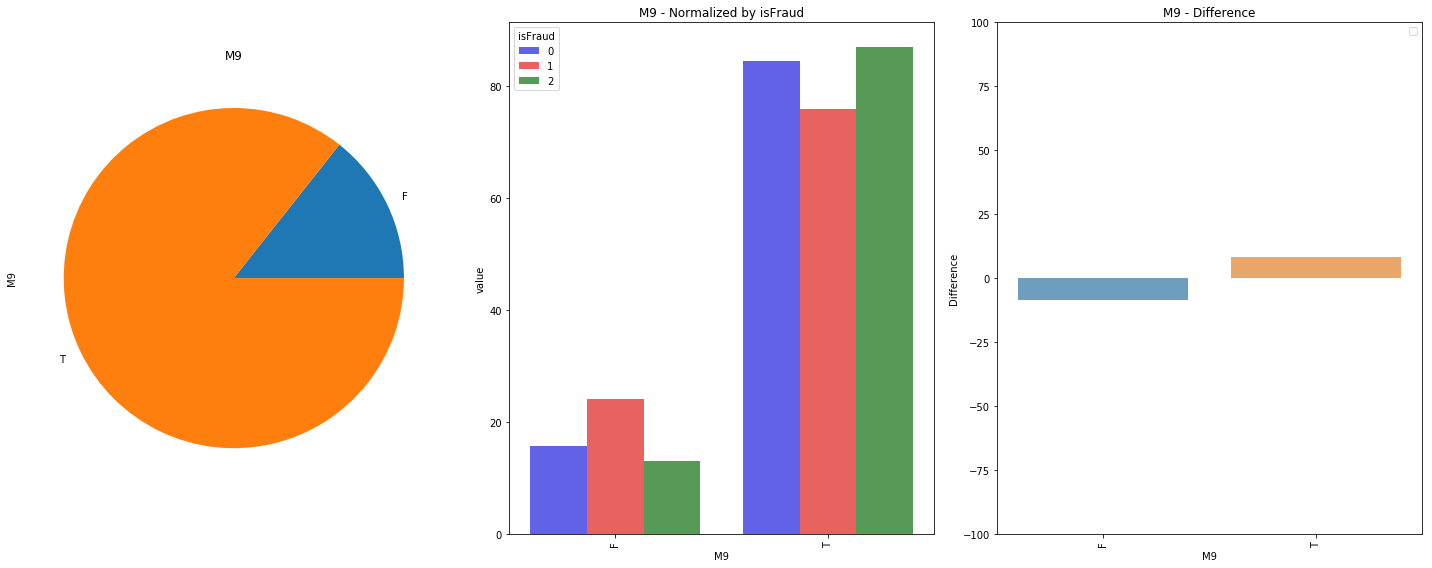

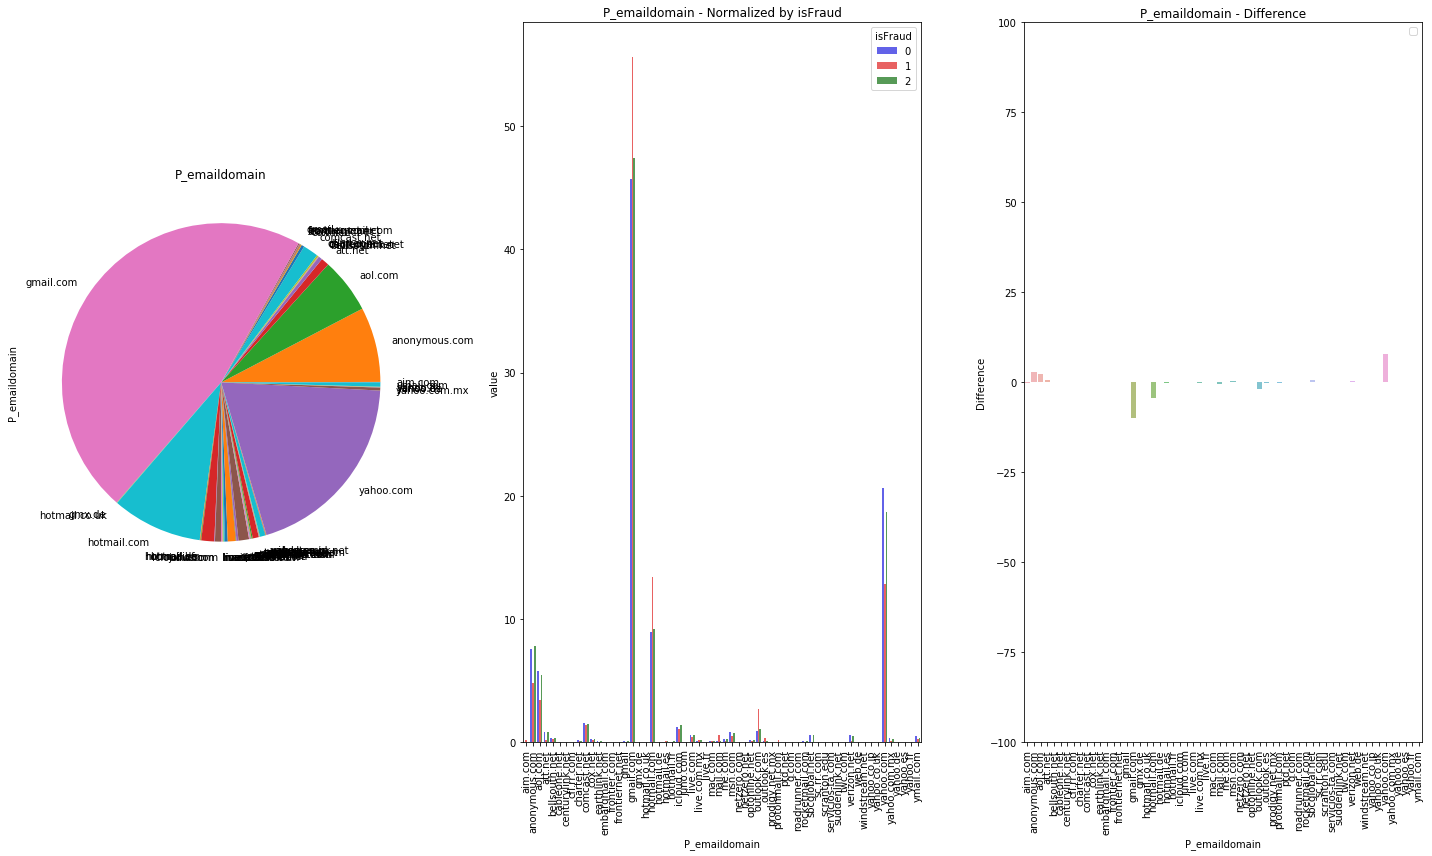

In [8]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['object']
feature_list = []

for feature in transaction.columns:
    if (feature not in rm_list) & (transaction[feature].dtypes in type_list):
        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_object(transaction,feature)

## For Numeric features with more than 10 unique values, I use boxplot and density plot to see the distribution

In [9]:
def eda_numeric(df,feature):
    x_ = df[feature]+0.01
    y_ = df['isFraud']
    data = pd.concat([x_,y_],1)
    plt.figure(figsize=[20,5])

    ax1 = plt.subplot(1,2,1)
    sns.boxplot(x='isFraud',y=feature,data=data)
    plt.title(feature+ " - Boxplot")
    upper_0 = data[data['isFraud']==0][feature].quantile(q=0.80)
    upper_1 = data[data['isFraud']==1][feature].quantile(q=0.80)
    lower_0 = data[data['isFraud']==0][feature].quantile(q=0.20)
    lower_1 = data[data['isFraud']==1][feature].quantile(q=0.20)

    ax1.set(ylim=(min(lower_0,lower_1),max(upper_0,upper_1)))

    ax2 = plt.subplot(1,2,2)
    plt.title(feature+ " - Density with Log")

    p1=sns.kdeplot(data[data['isFraud']==0][feature].apply(np.log), color="b",legend=False)
    p2=sns.kdeplot(data[data['isFraud']==1][feature].apply(np.log), color="r",legend=False)
    p3=sns.kdeplot(data[data['isFraud']==2][feature].apply(np.log), color="g",shade = True,linestyle = '--',alpha =0.3,legend=False)
    plt.legend(loc='upper right', labels=['0', '1', '2'])

    plt.tight_layout()
    plt.show()

To save space, I just draw 10 available features

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


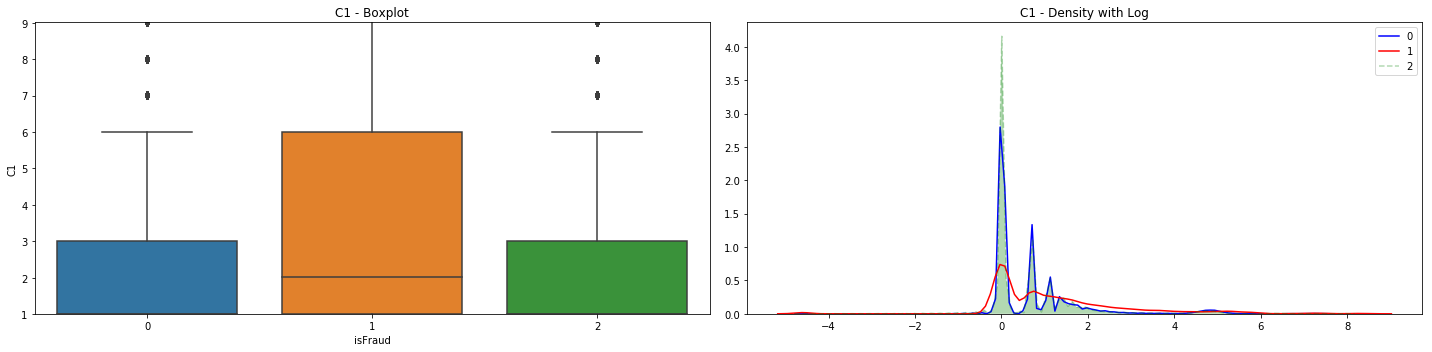

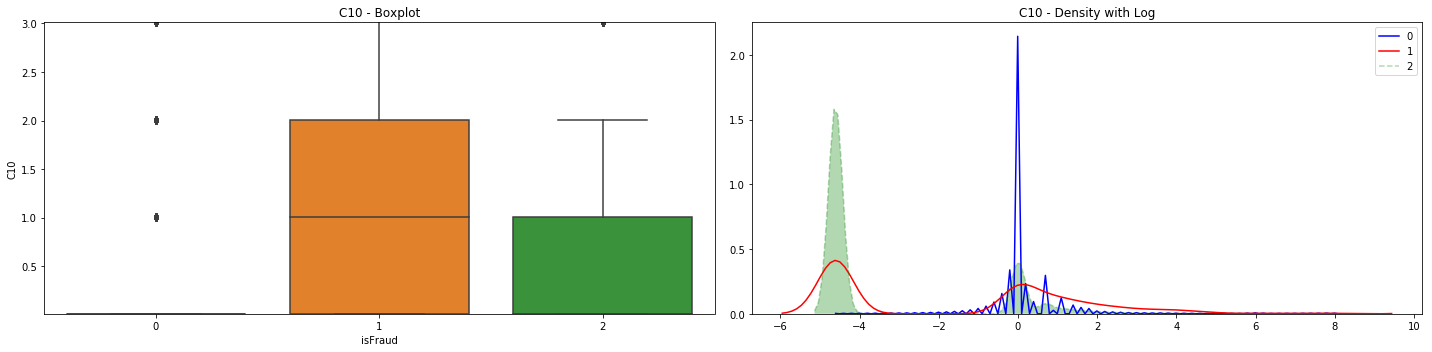

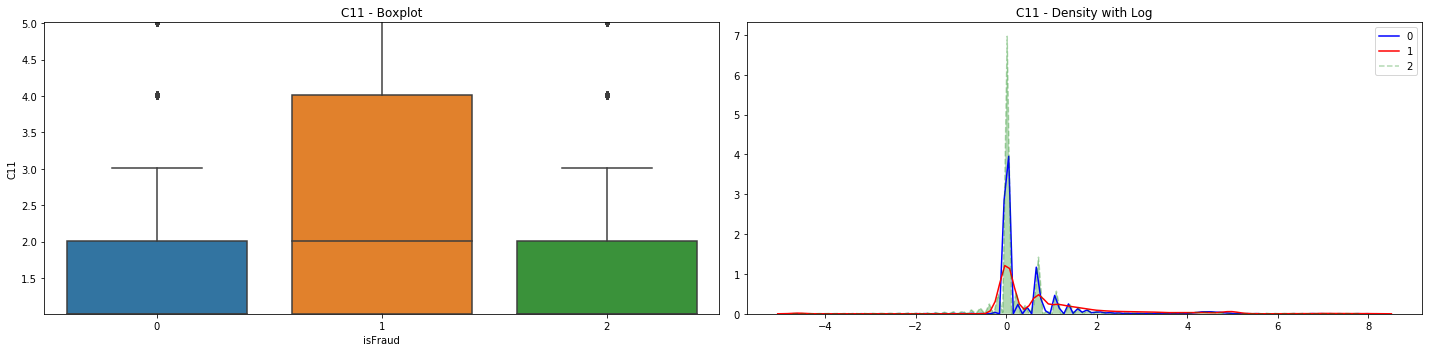

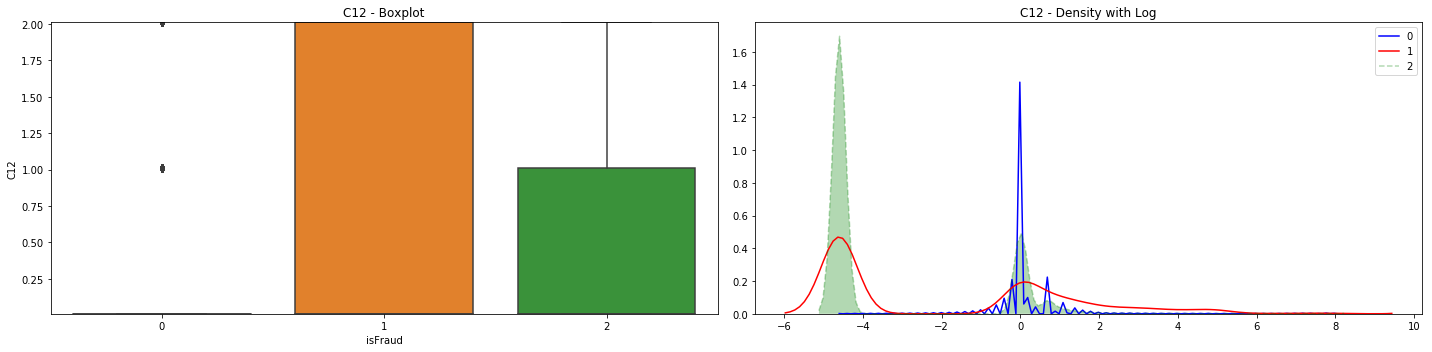

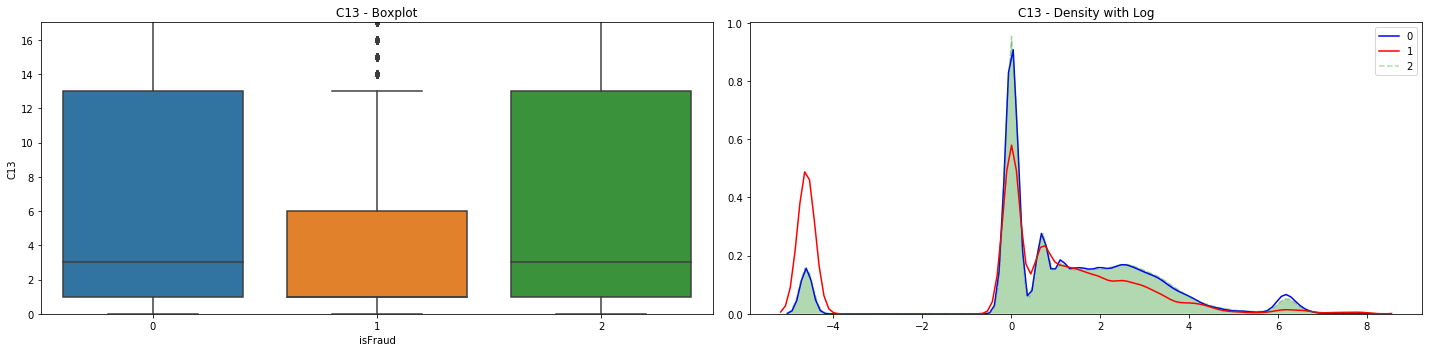

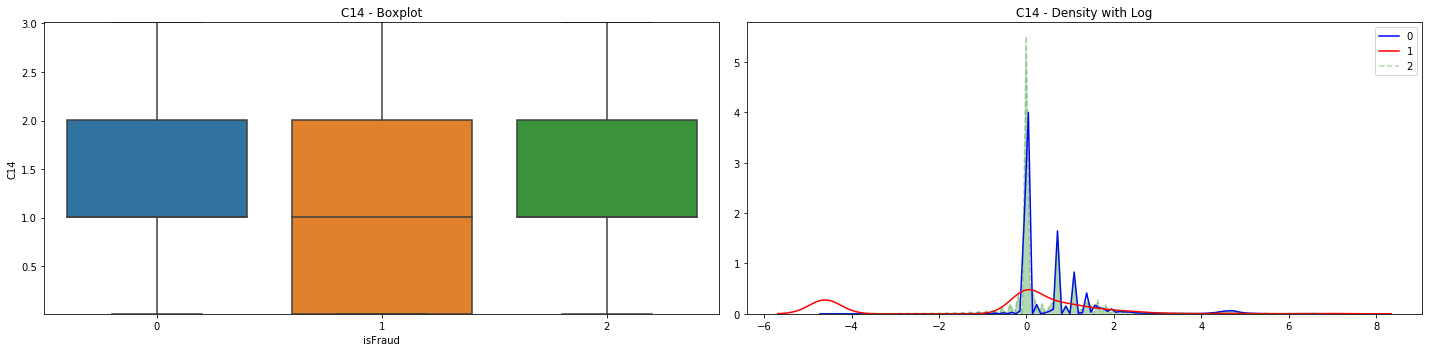

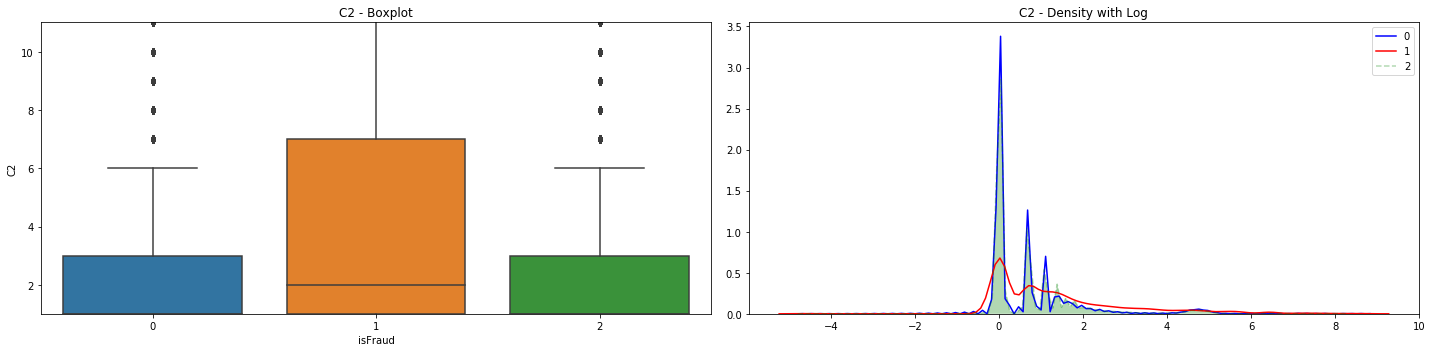

/opt/conda/lib/python3.6/site-packages/matplotlib/artist.py:913: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.01, top=0.01
  return func(v)


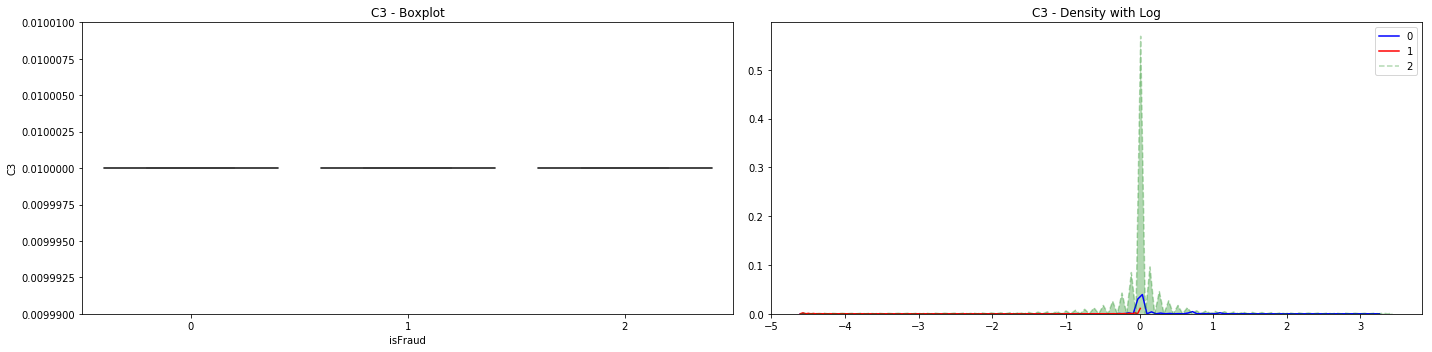

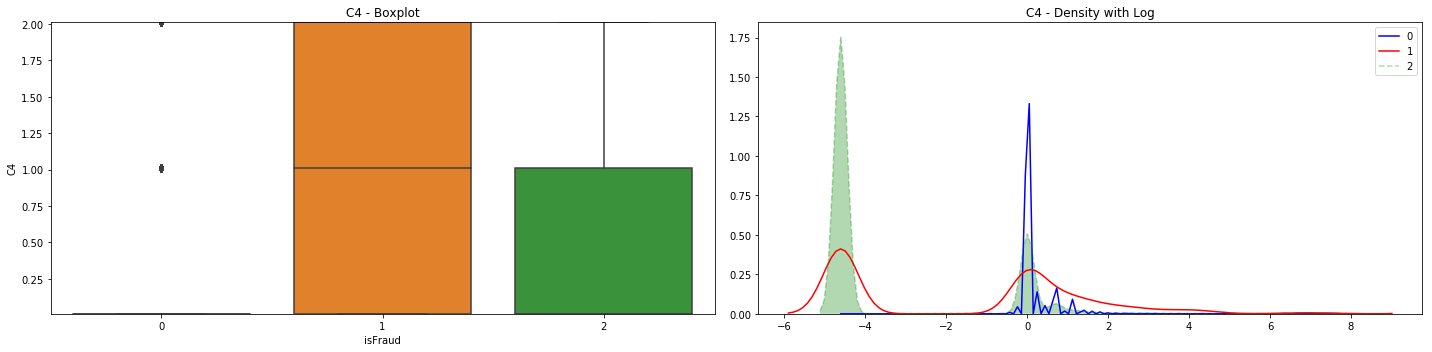

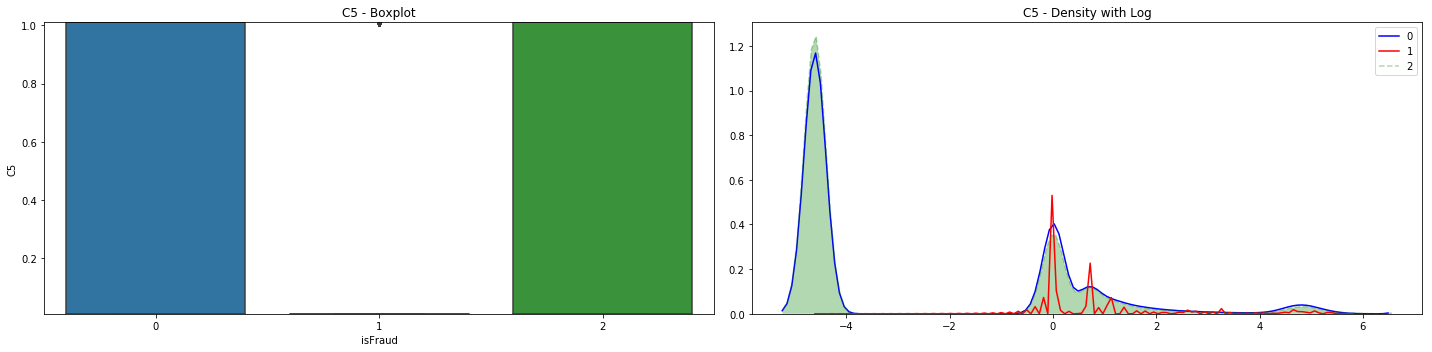

In [10]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['int64','float']
feature_list = []

for feature in transaction.columns:
    if (feature not in rm_list) & (transaction[feature].dtypes in type_list) & (len(transaction[feature].unique()) > 10):

        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_numeric(transaction,feature)

# EDA Identity Dataset

I will break down into 2 types: Distributions of identity by PEOPLE and Distribution of identity by TRANSACTION

### By PEOPLE

In [11]:
isFraud_trans_id_0 = transaction[transaction['isFraud'] == 0]['TransactionID']
isFraud_trans_id_1 = transaction[transaction['isFraud'] == 1]['TransactionID']
isFraud_trans_id_2 = transaction[transaction['isFraud'] == 2]['TransactionID']

In [12]:
identity = pd.concat([train_identity,test_identity],axis = 0)
identity['isFraud'] = np.where(identity.TransactionID.isin(isFraud_trans_id_0),0,
                               np.where(identity.TransactionID.isin(isFraud_trans_id_1),1,2))

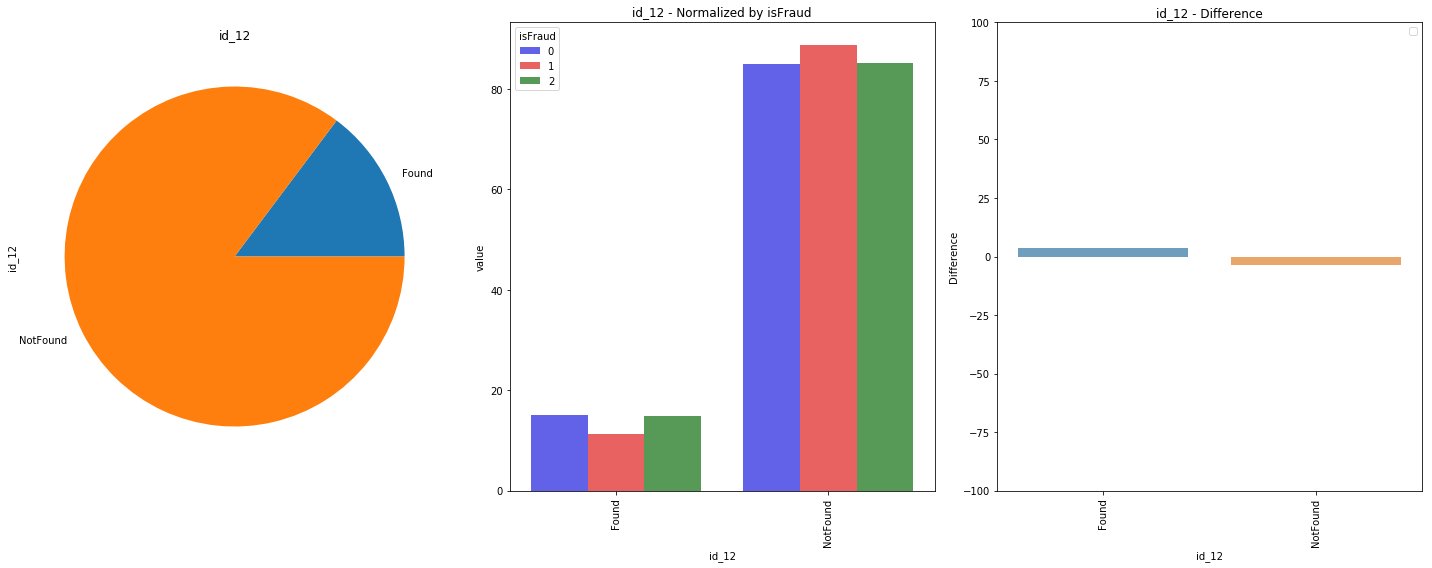

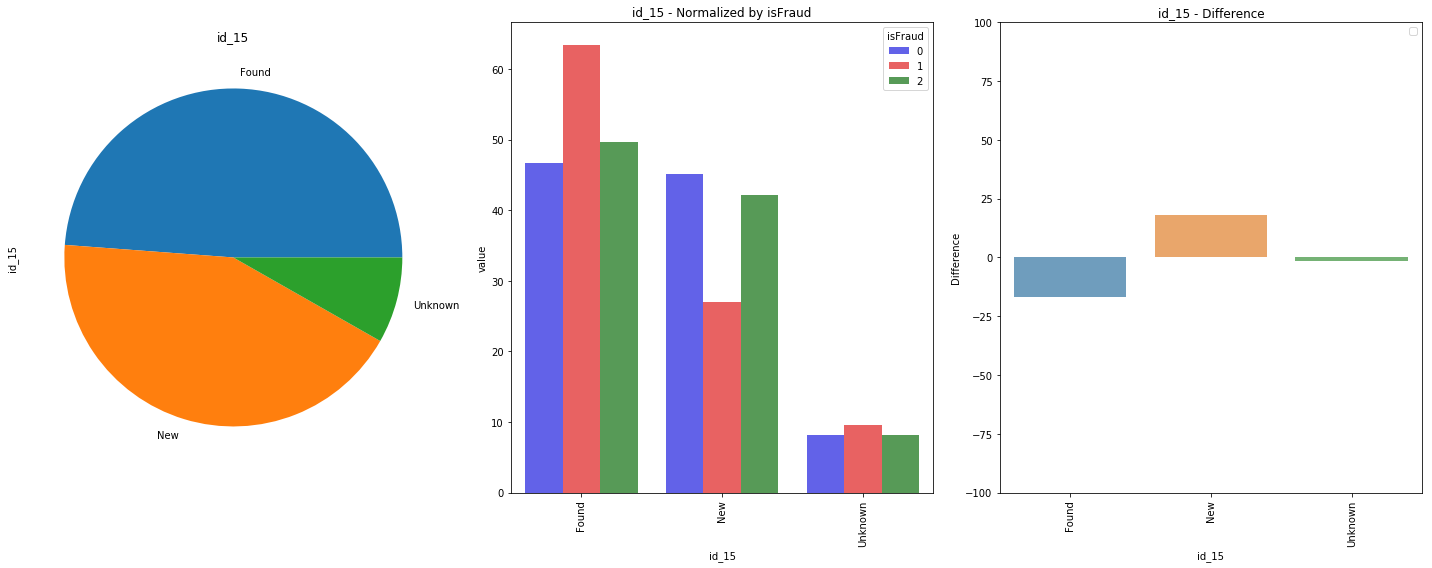

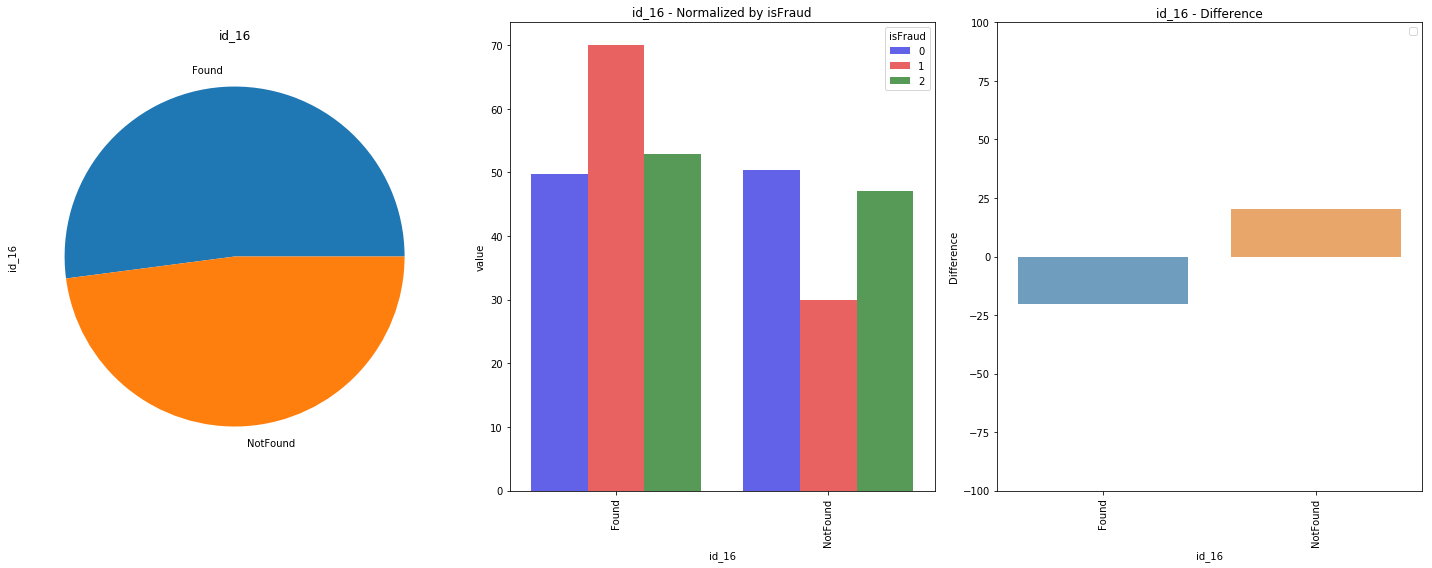

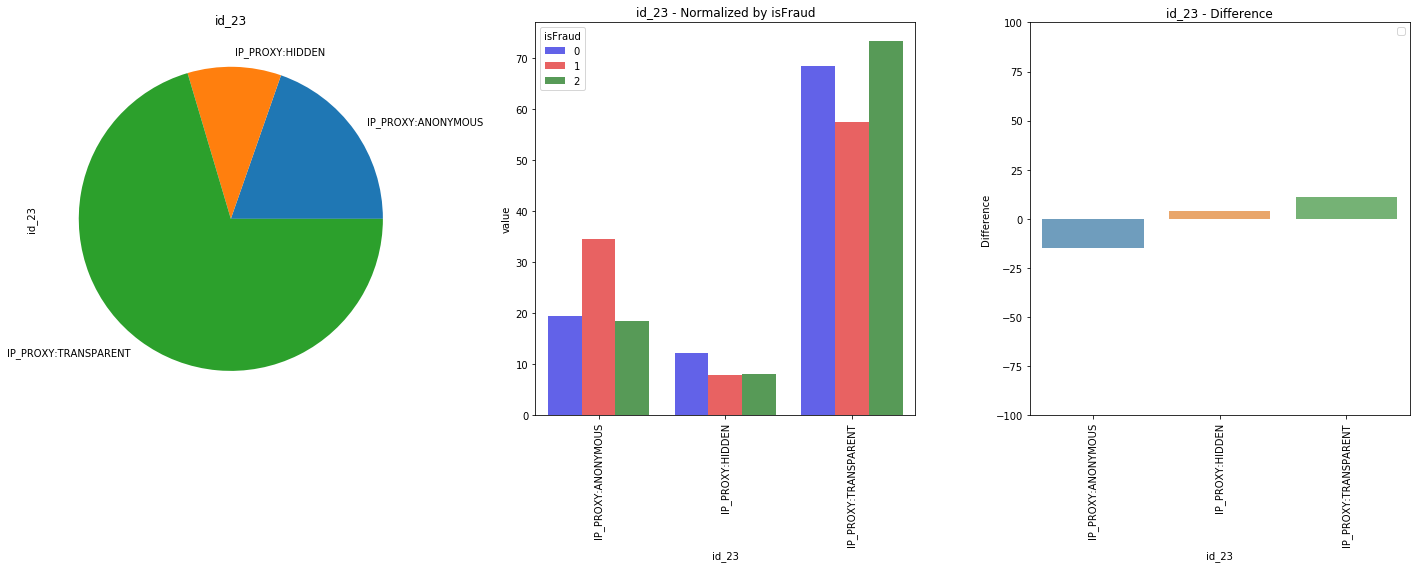

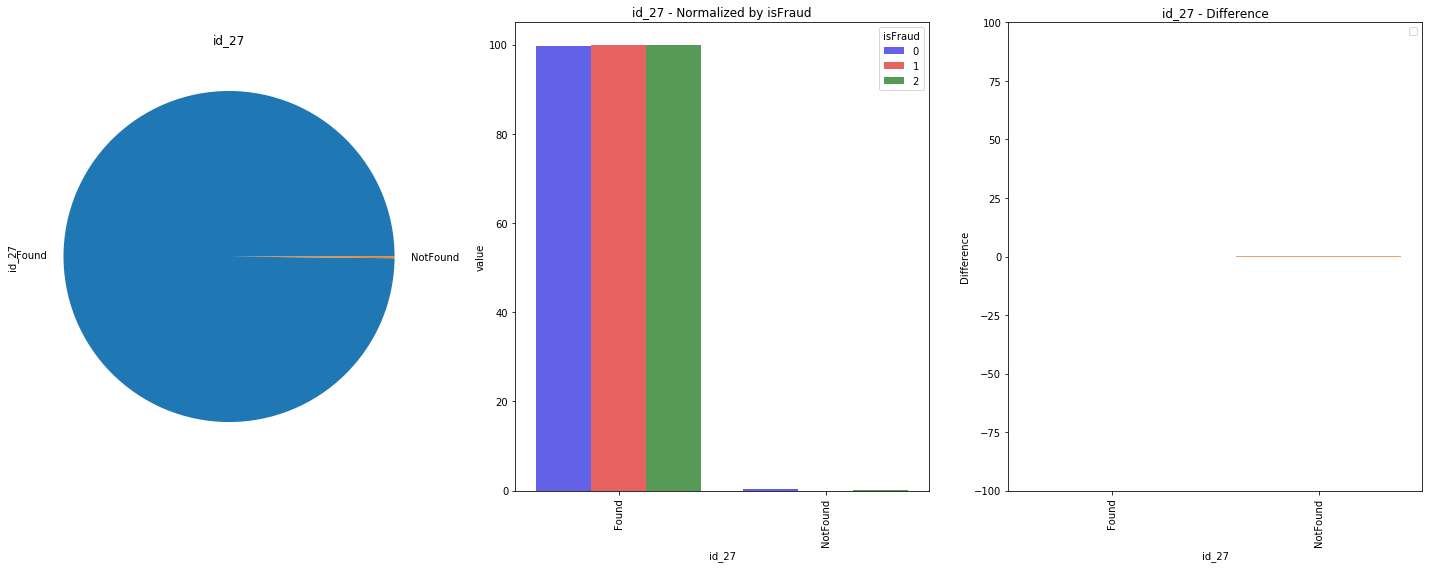

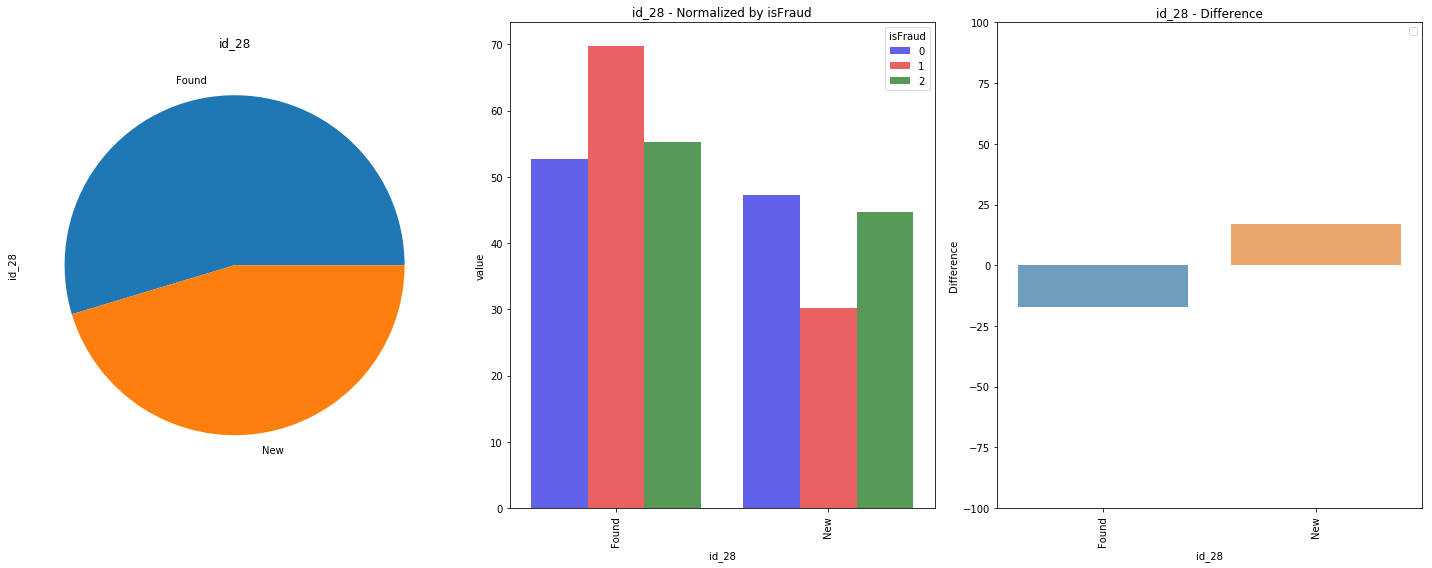

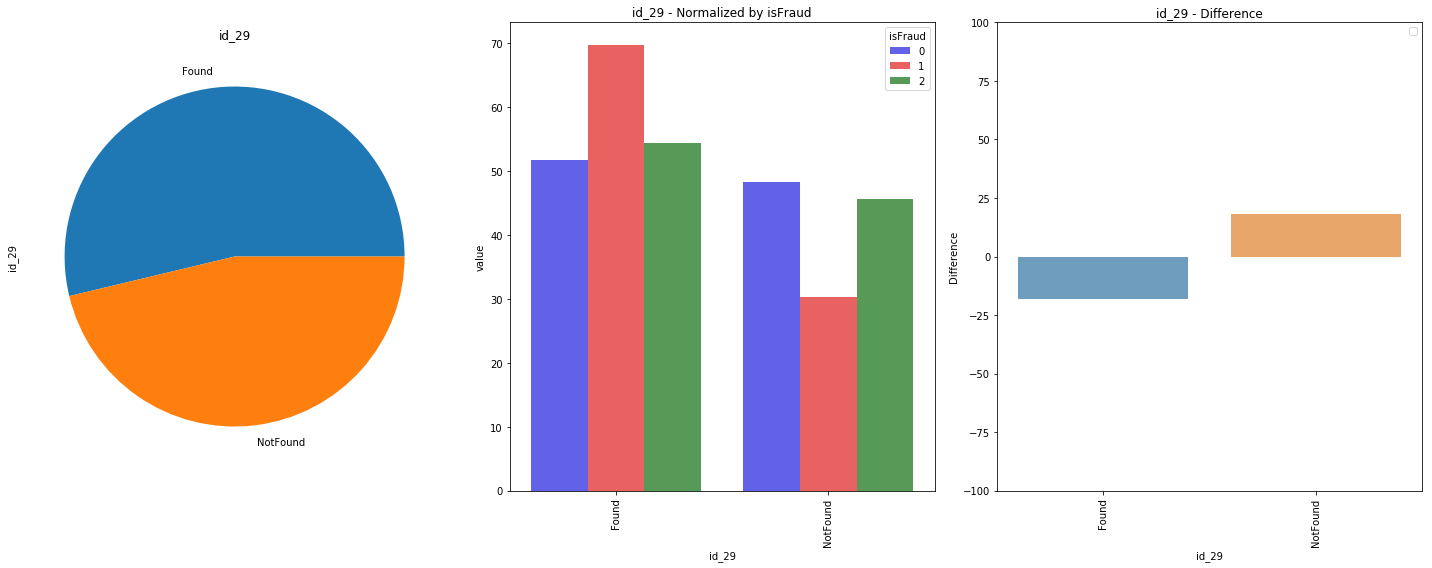

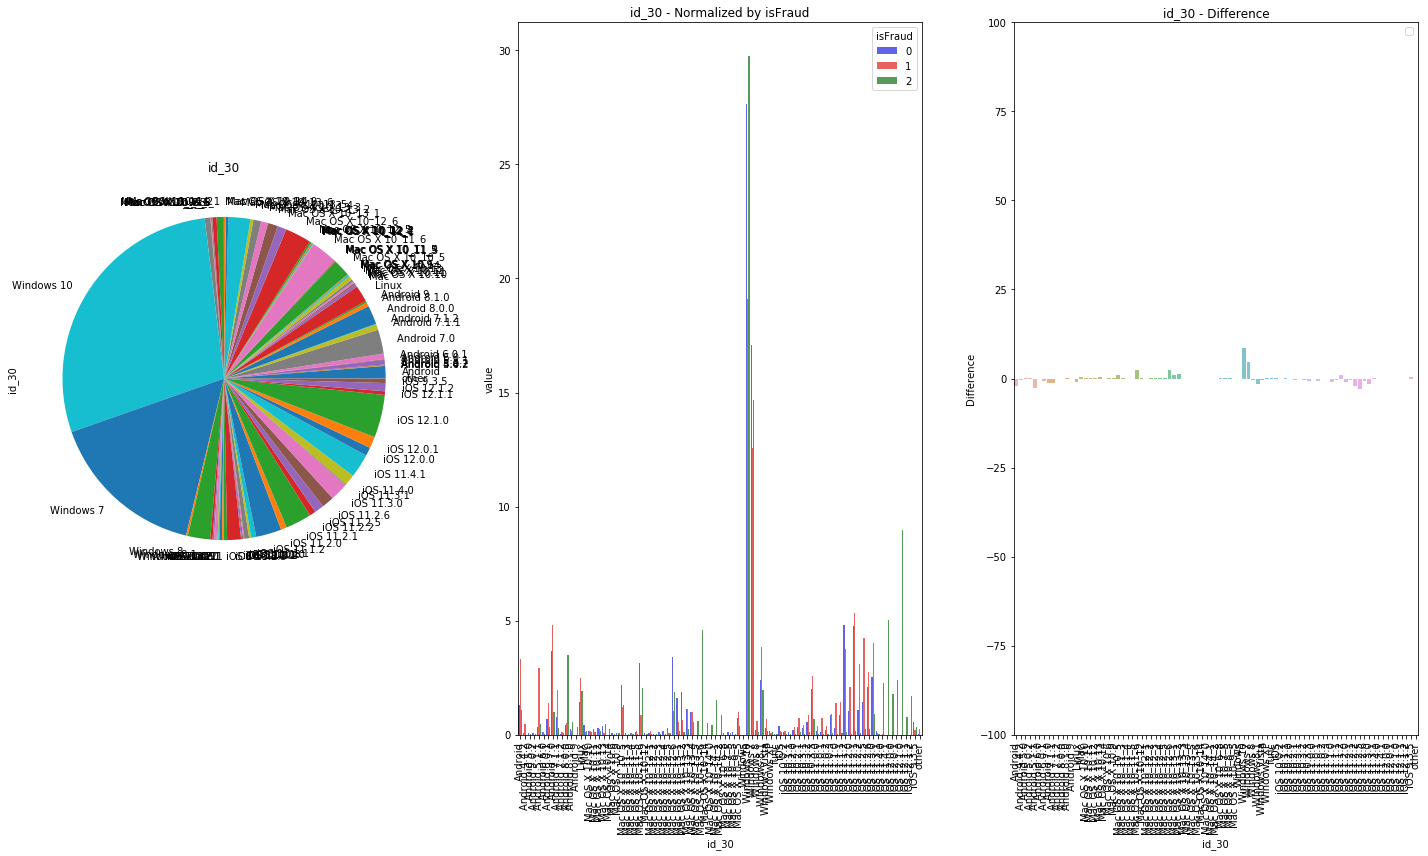

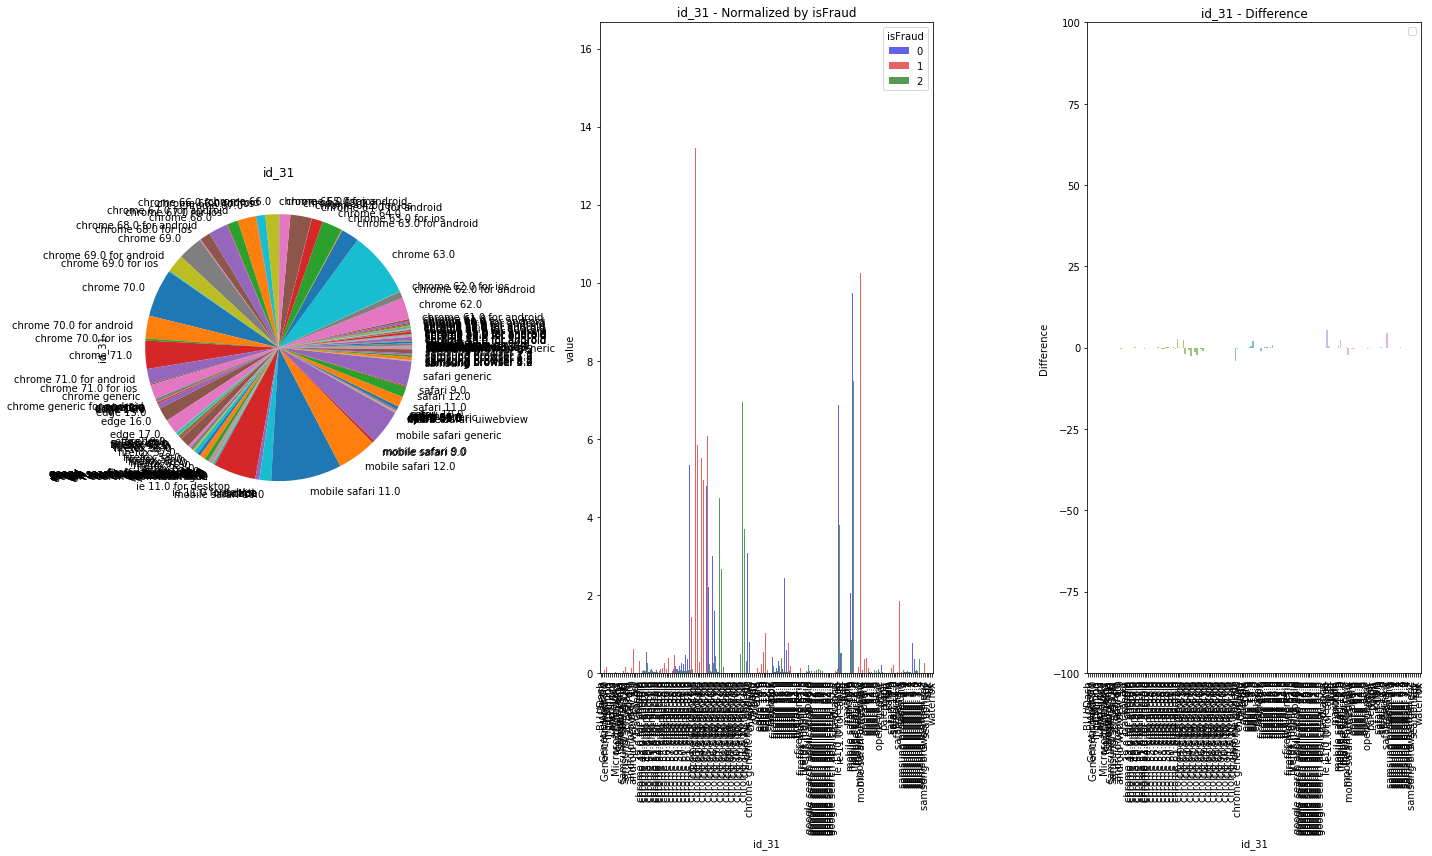

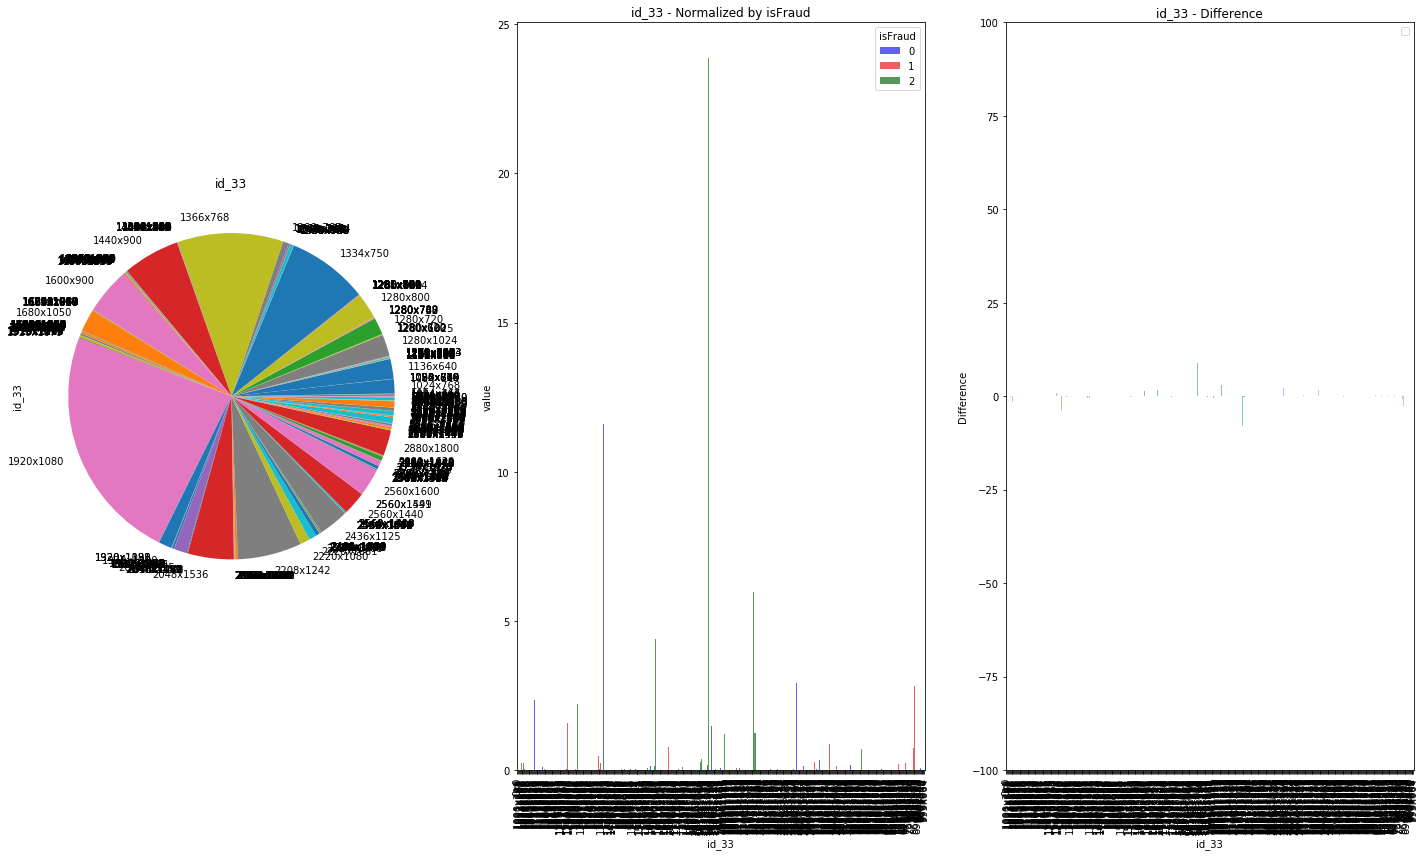

In [13]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['object']
feature_list = []

for feature in identity.columns:
    if (feature not in rm_list) & (identity[feature].dtypes in type_list):
        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_object(identity,feature)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


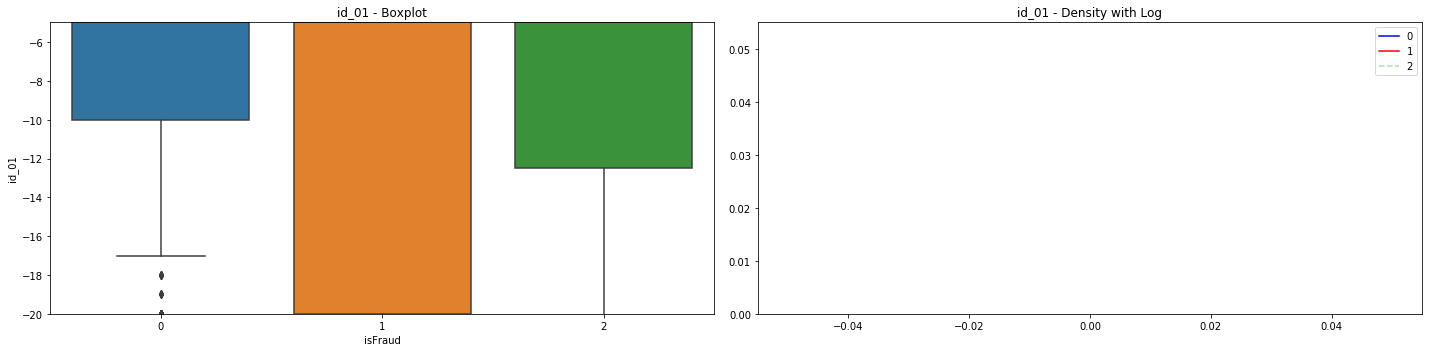

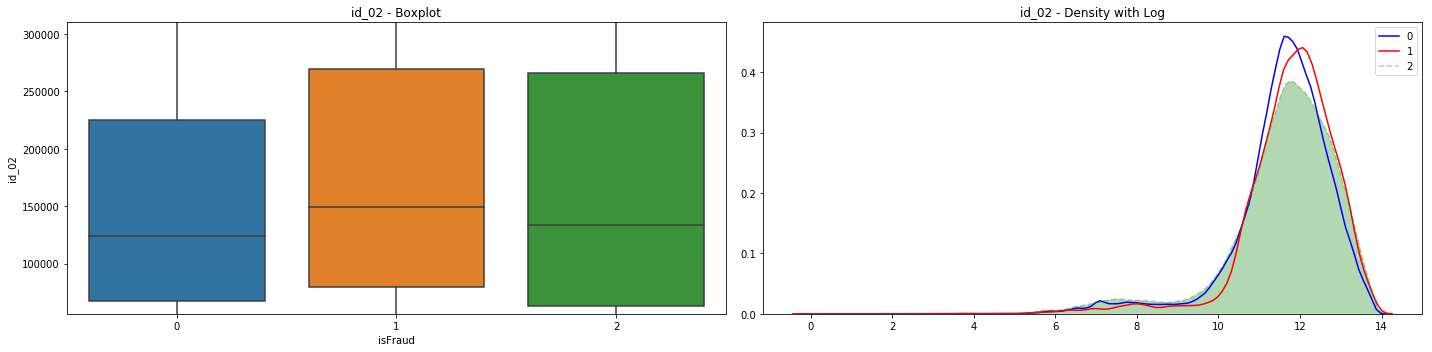

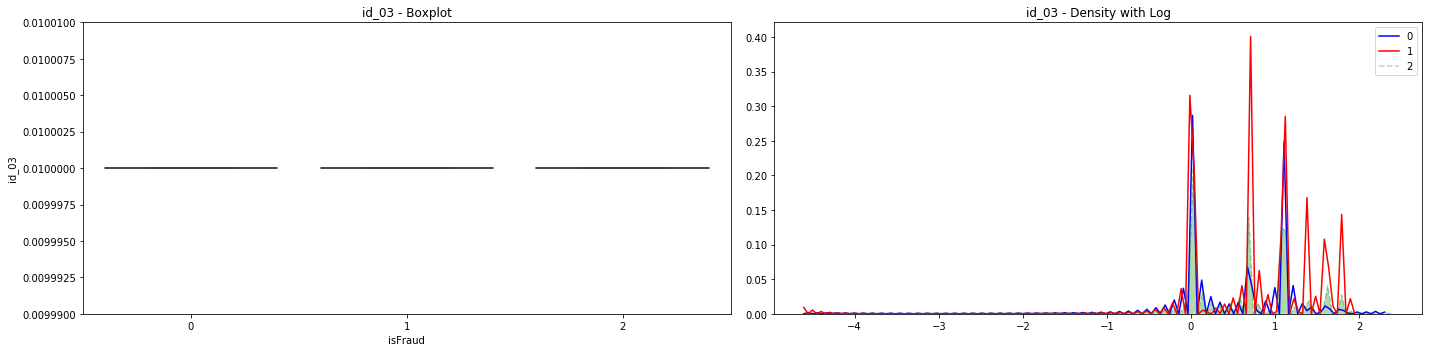

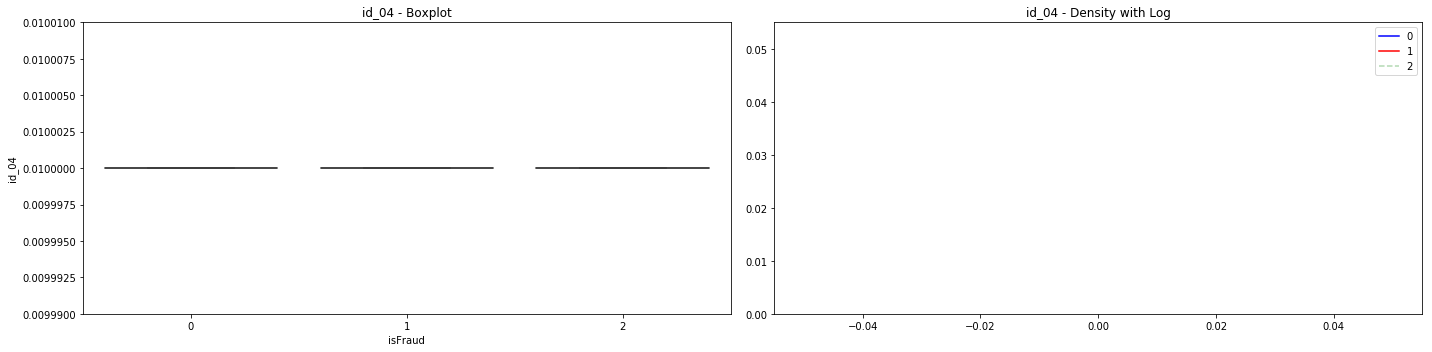

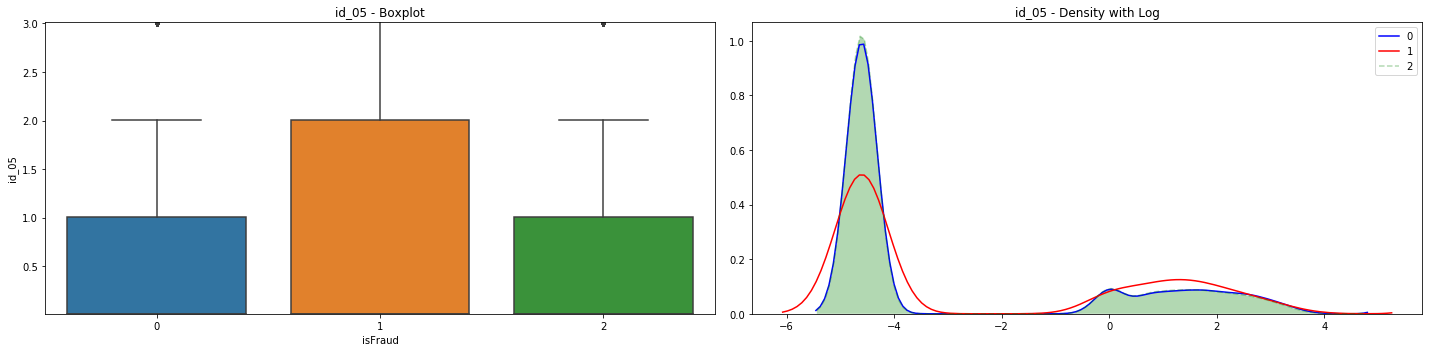

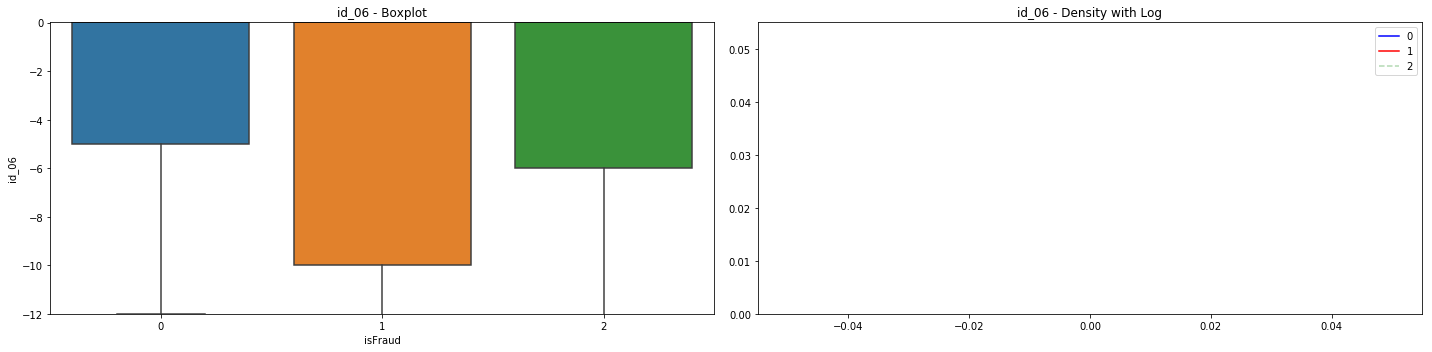

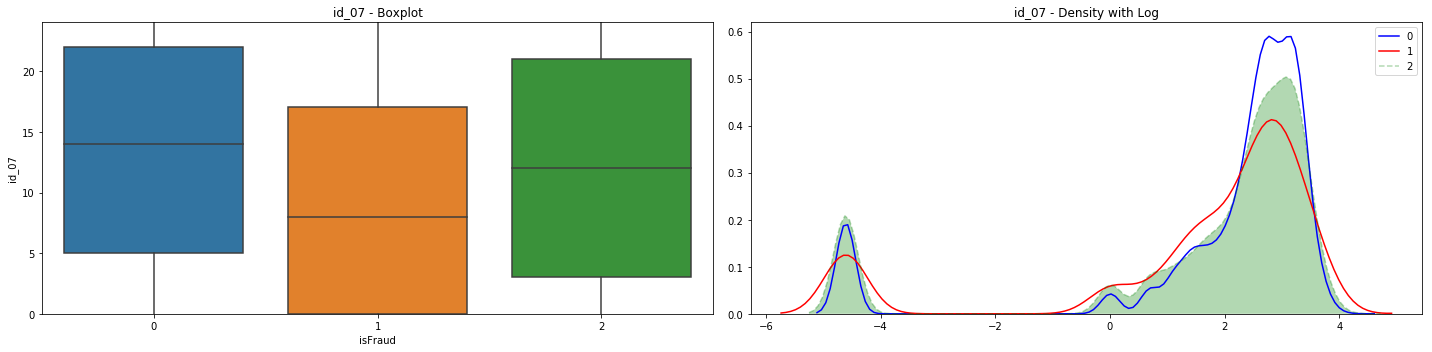

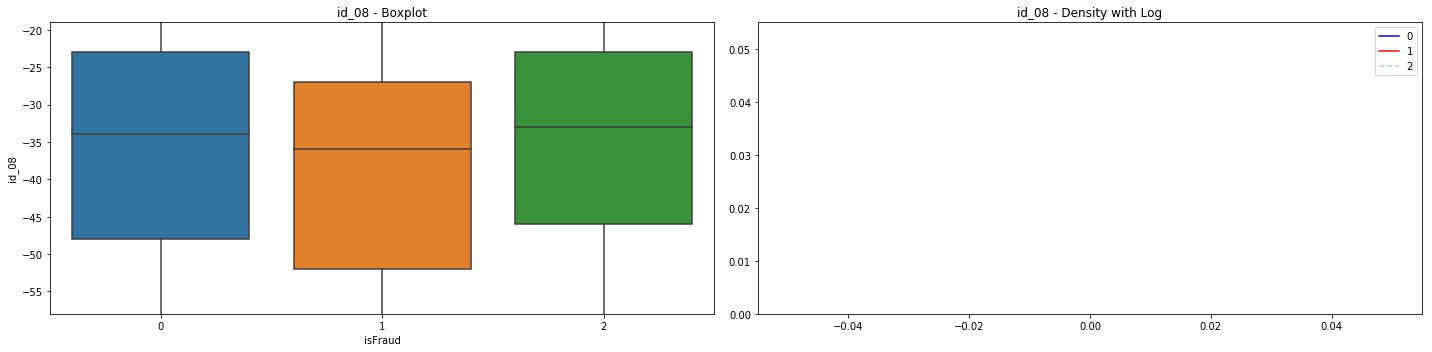

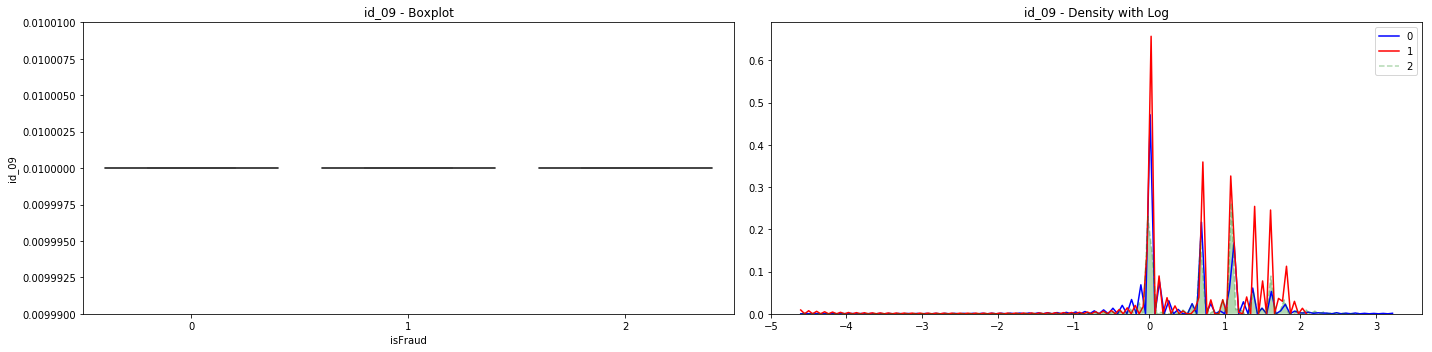

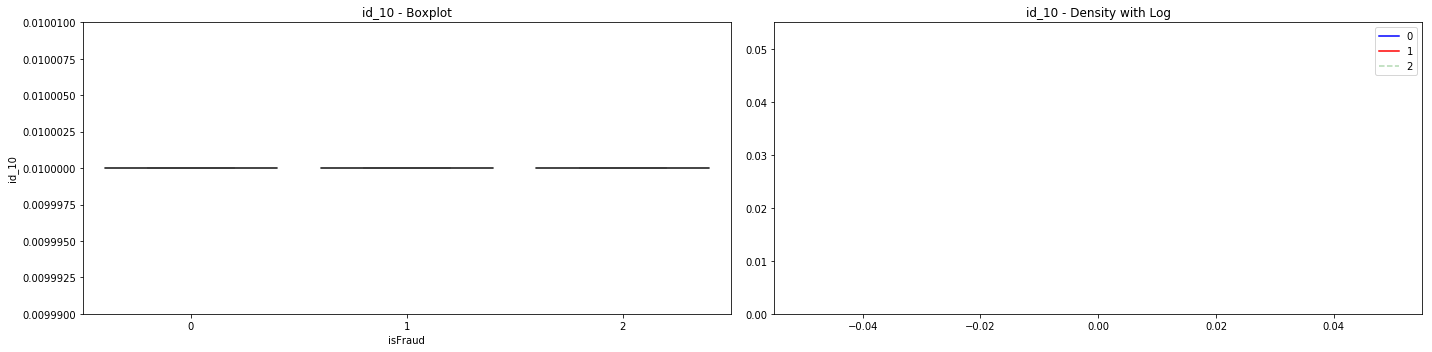

In [14]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['int64','float']
feature_list = []

for feature in identity.columns:
    if (feature not in rm_list) & (identity[feature].dtypes in type_list) & (len(identity[feature].unique()) > 10):

        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_numeric(identity,feature)

### BY TRANSACTION

In [15]:
transaction_identity = transaction[['TransactionID','isFraud']]
transaction_identity = transaction_identity.merge(identity,on='TransactionID',how='left')

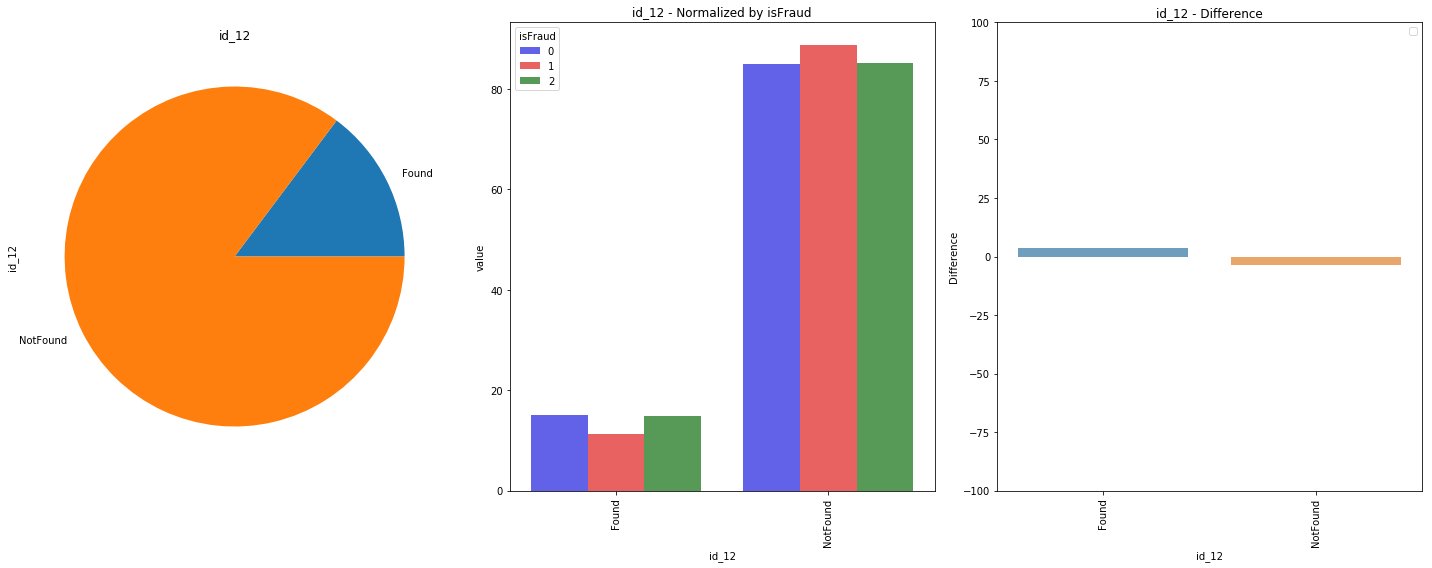

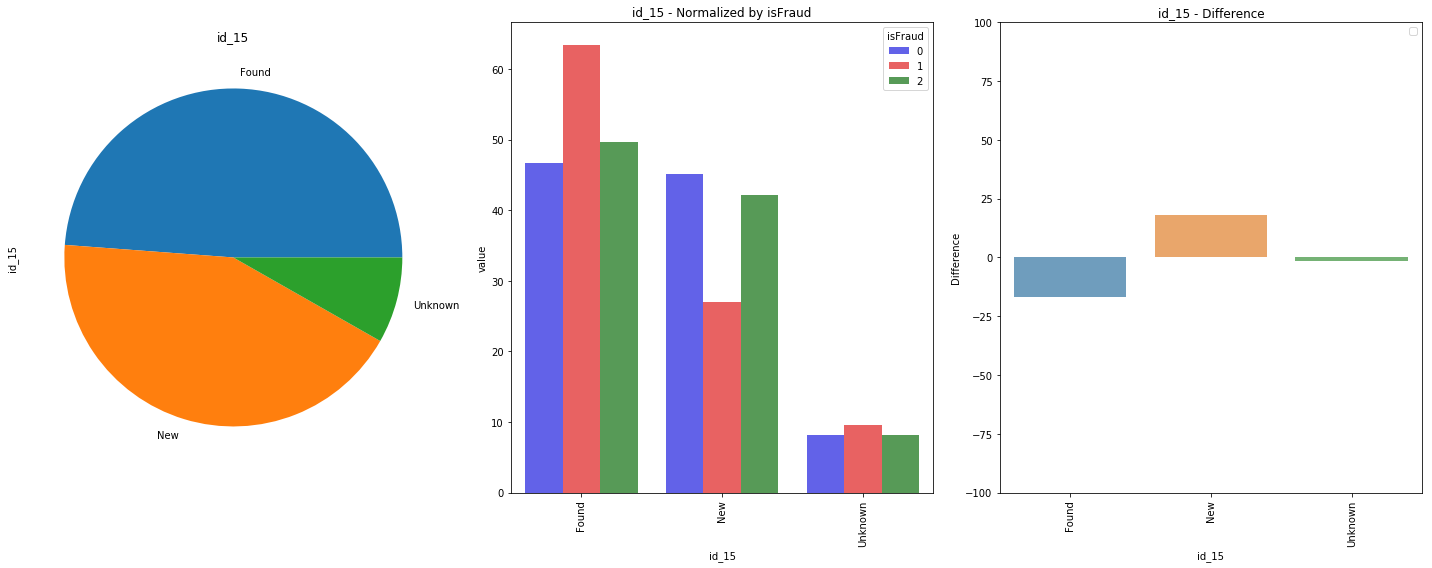

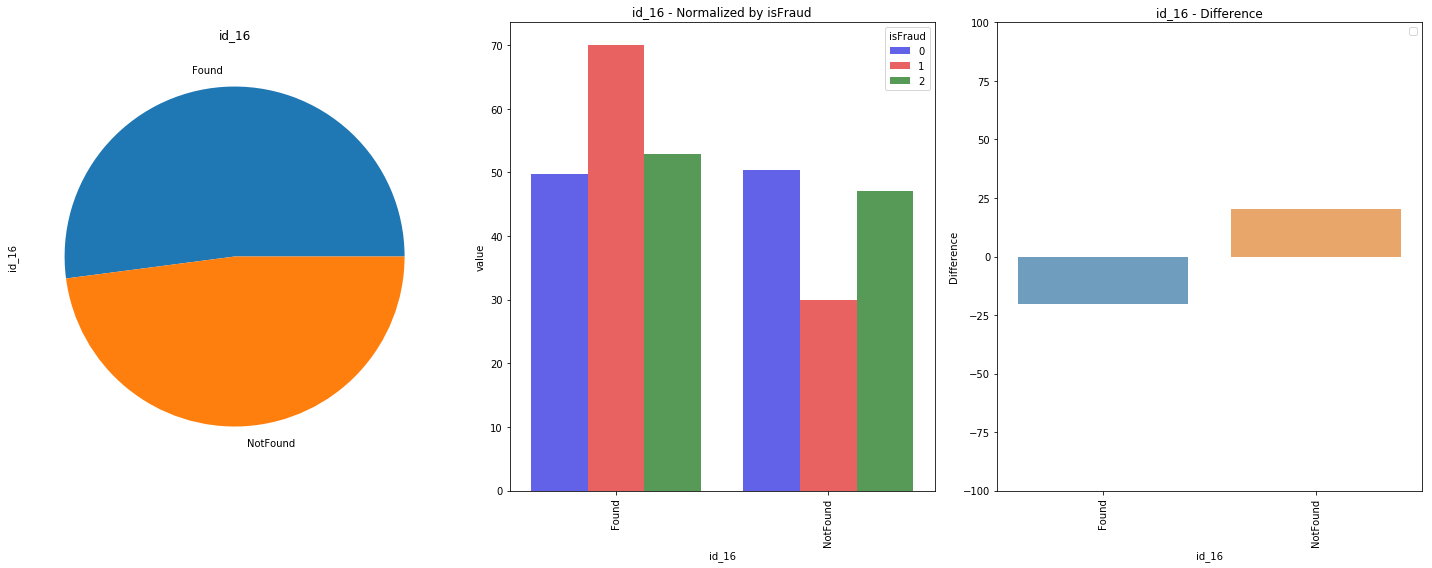

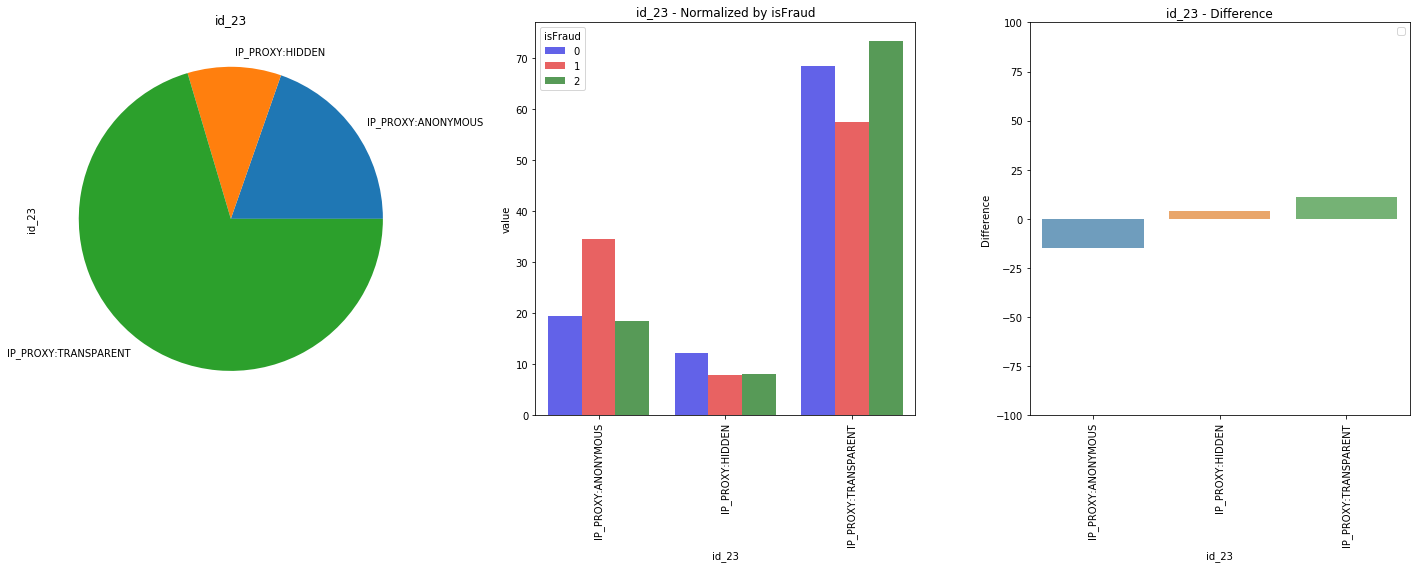

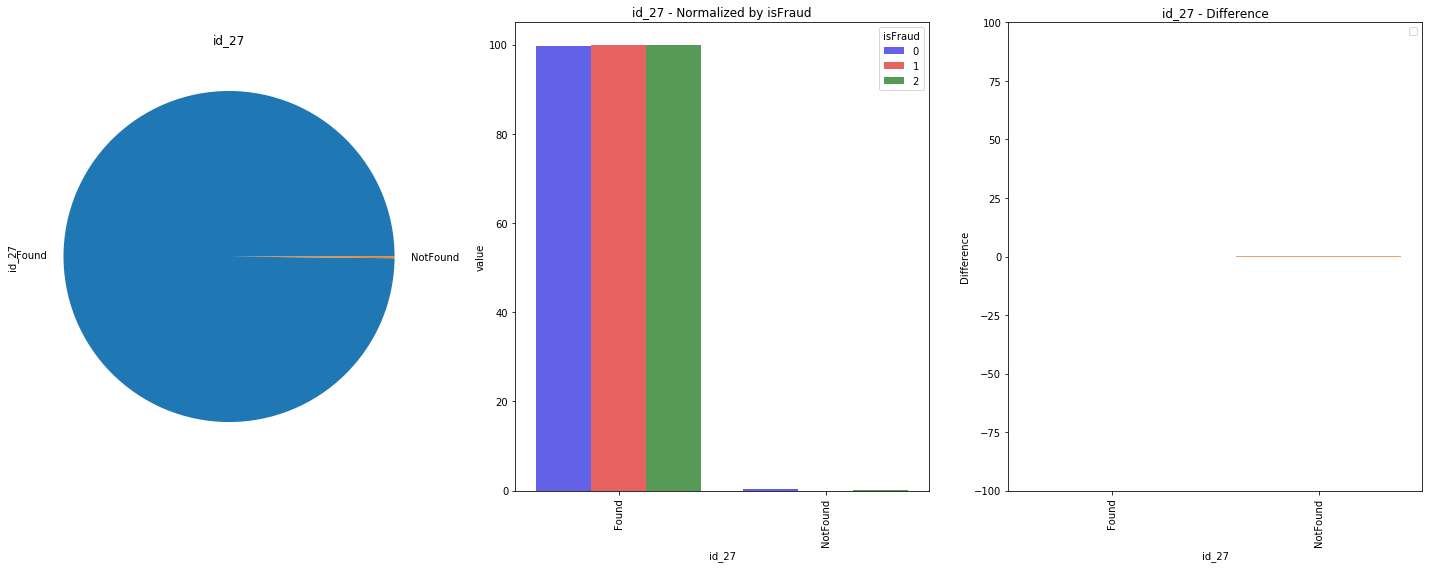

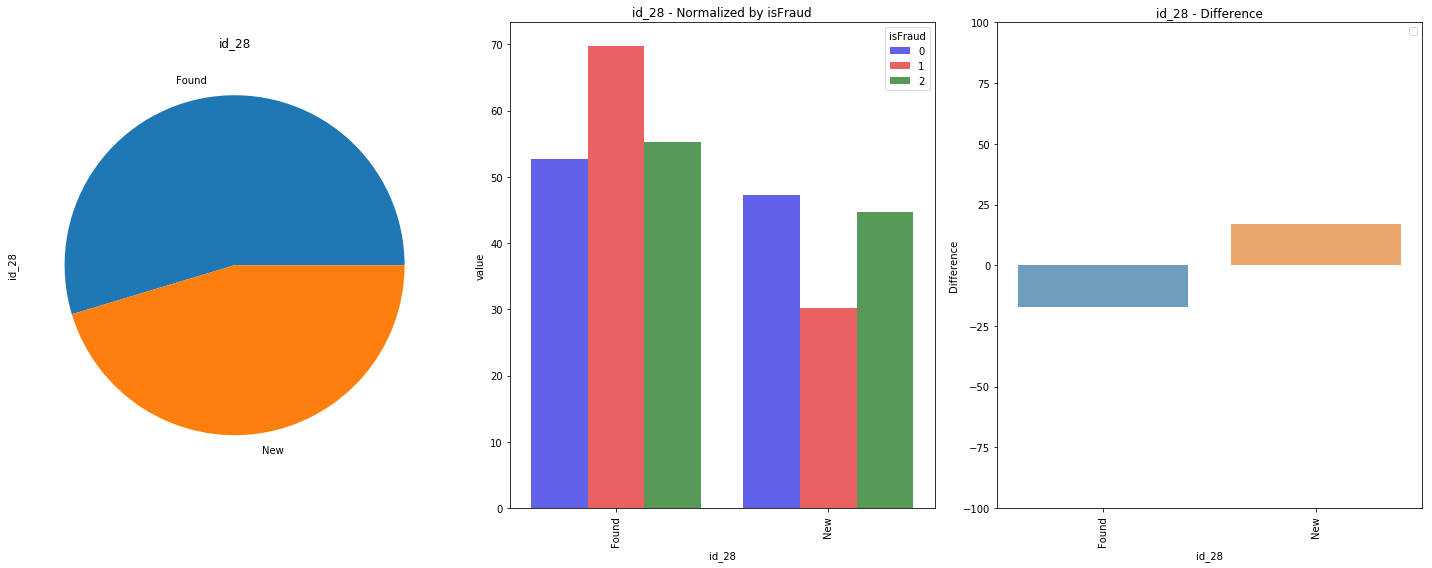

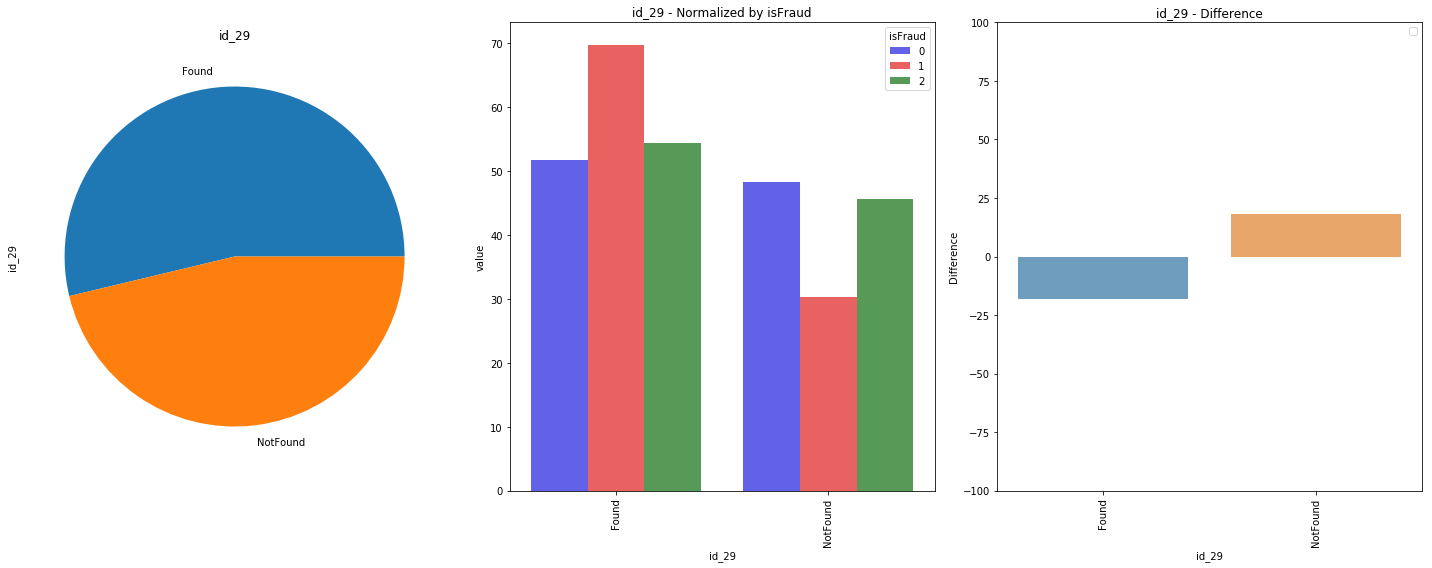

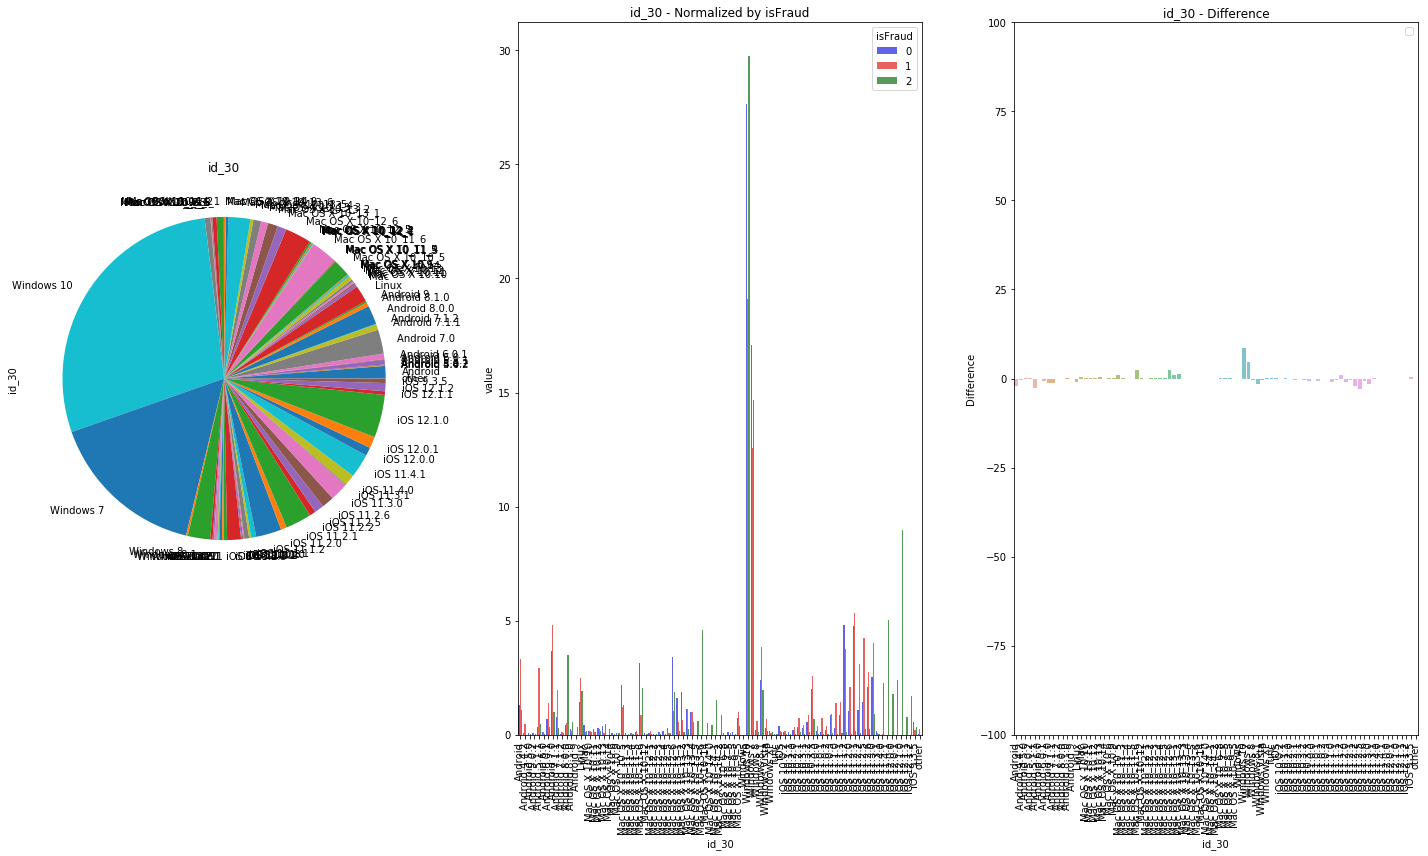

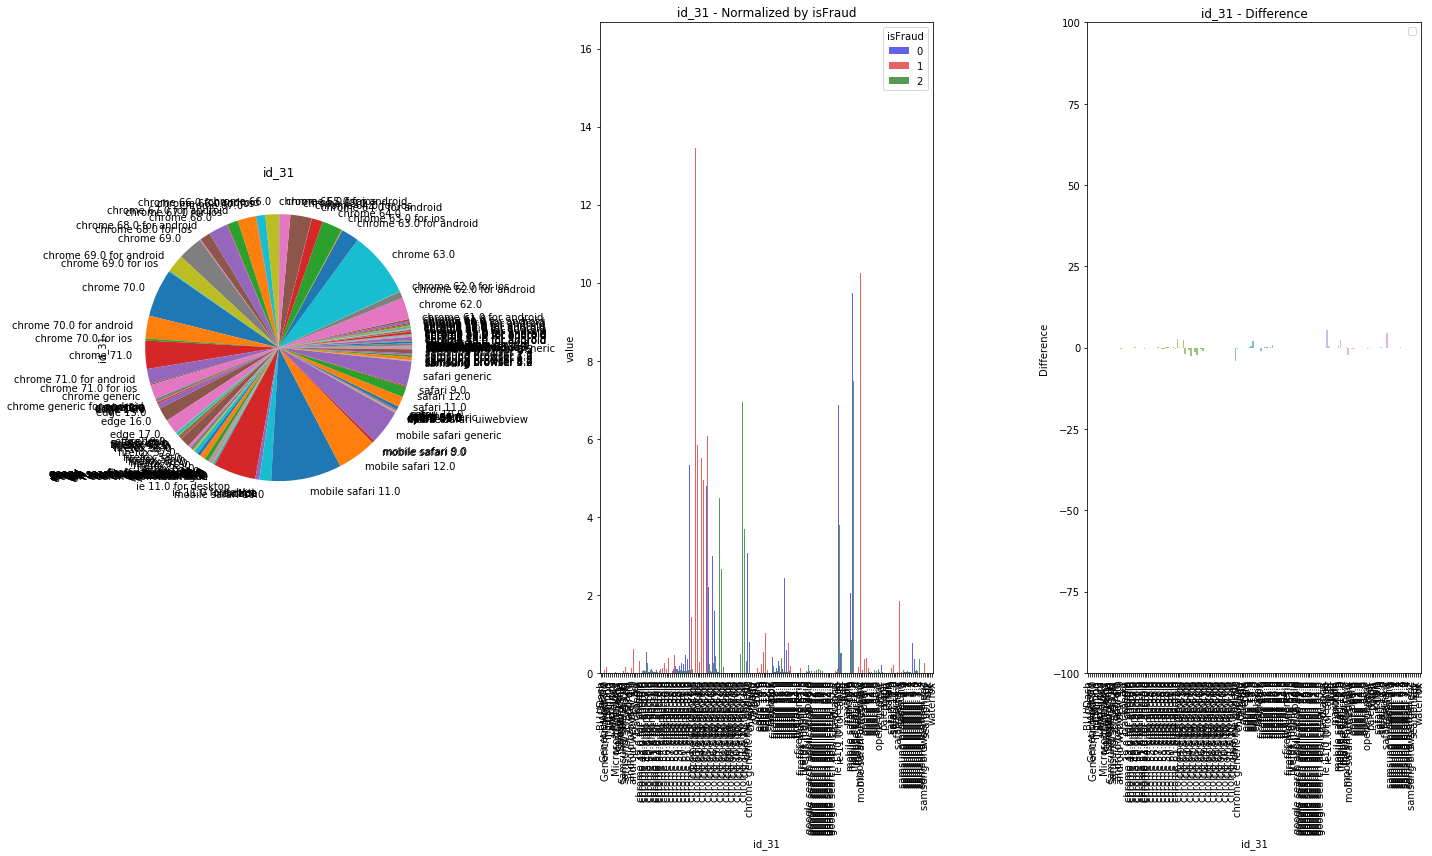

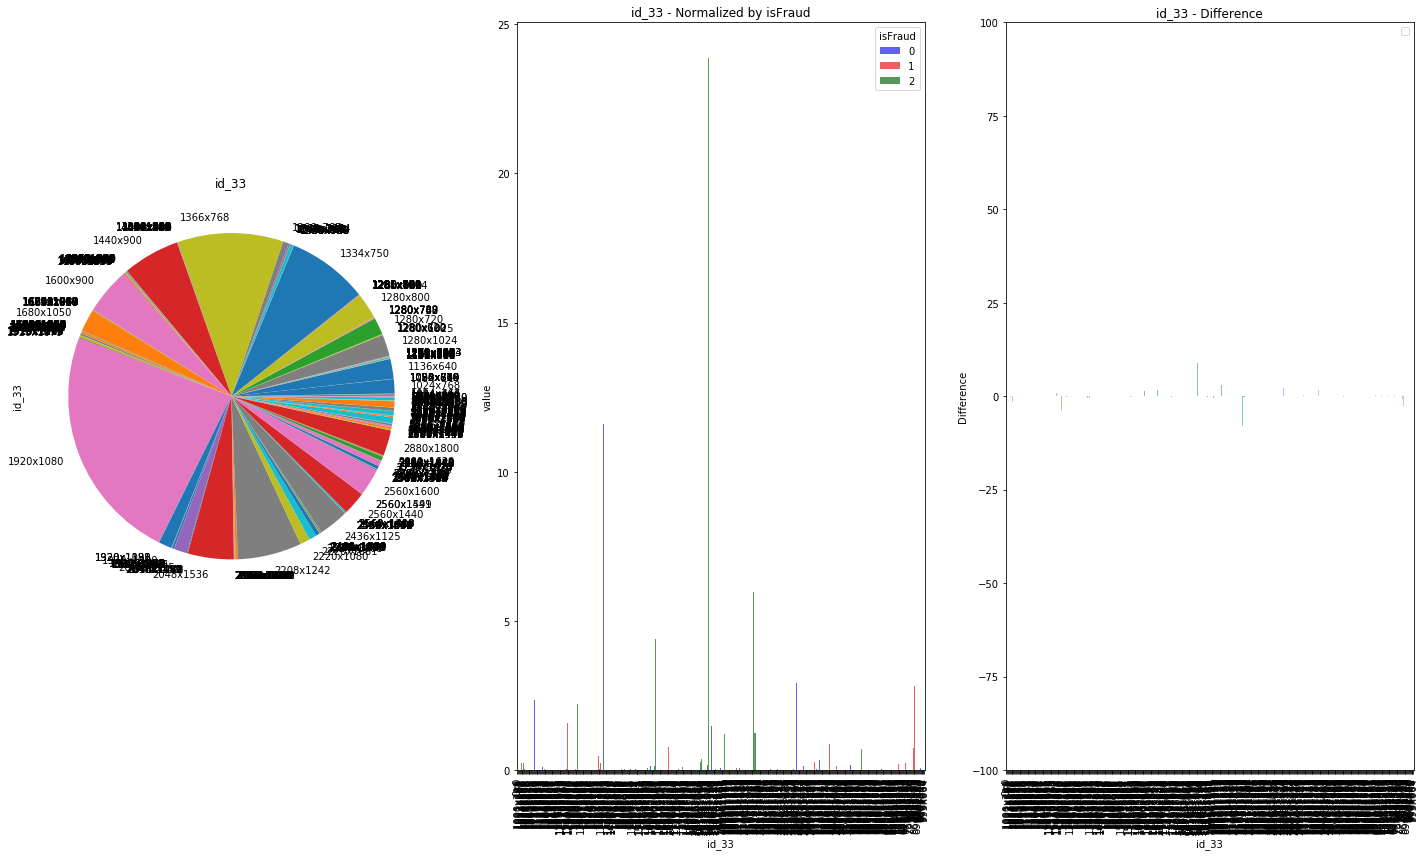

In [16]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['object']
feature_list = []

for feature in identity.columns:
    if (feature not in rm_list) & (identity[feature].dtypes in type_list):
        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_object(identity,feature)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


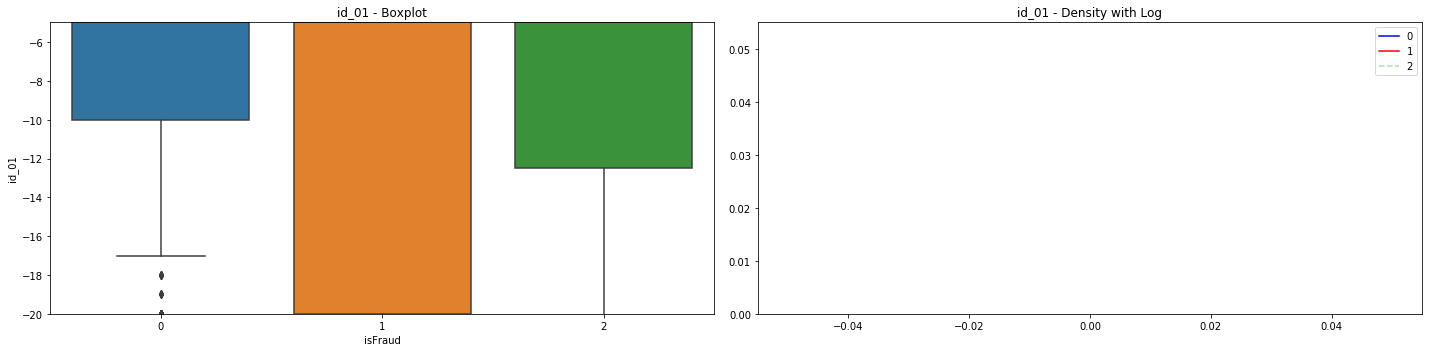

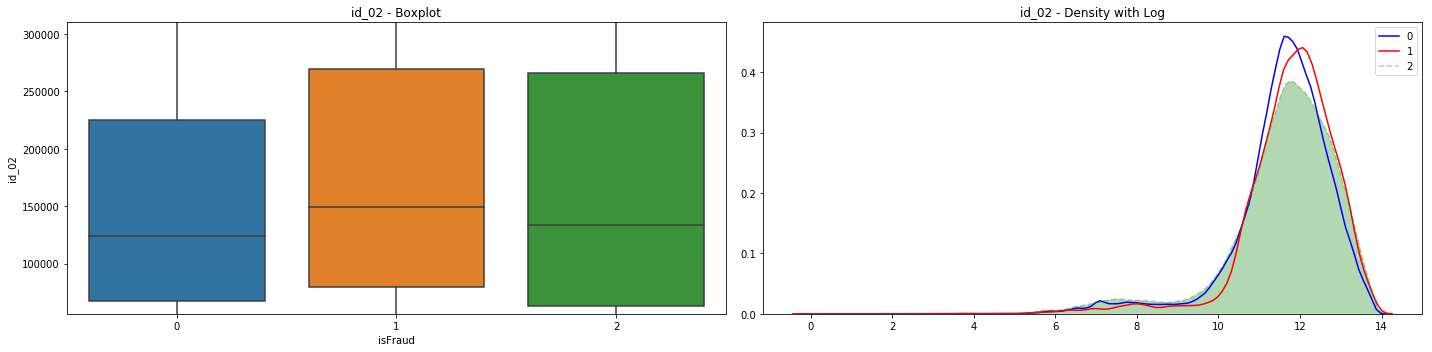

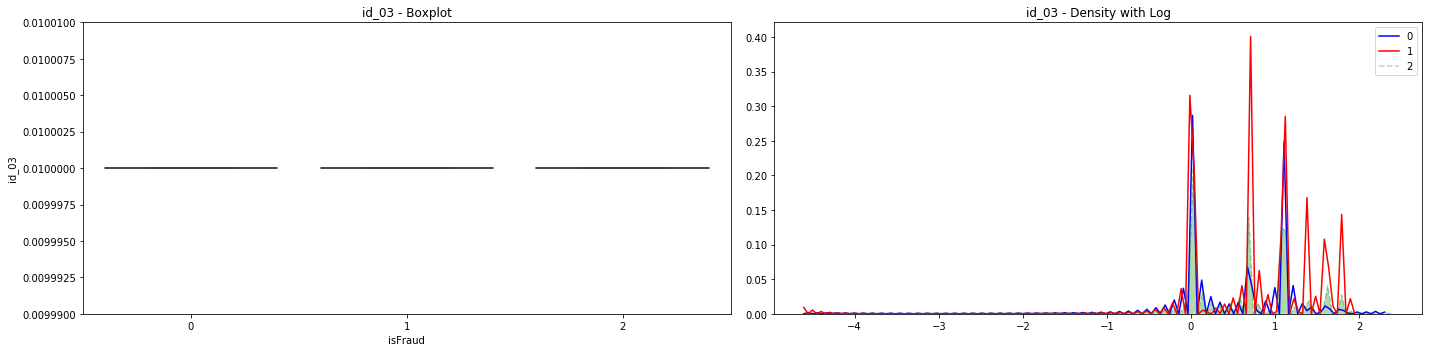

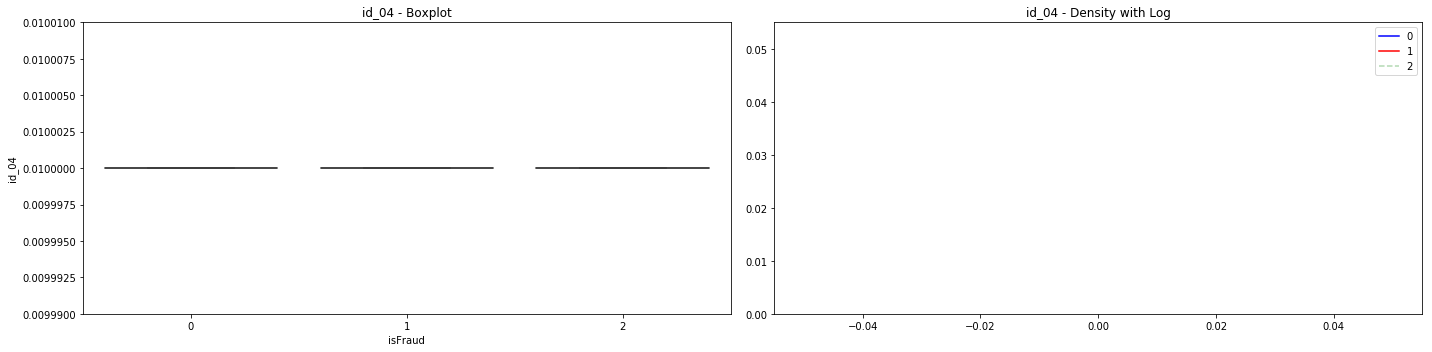

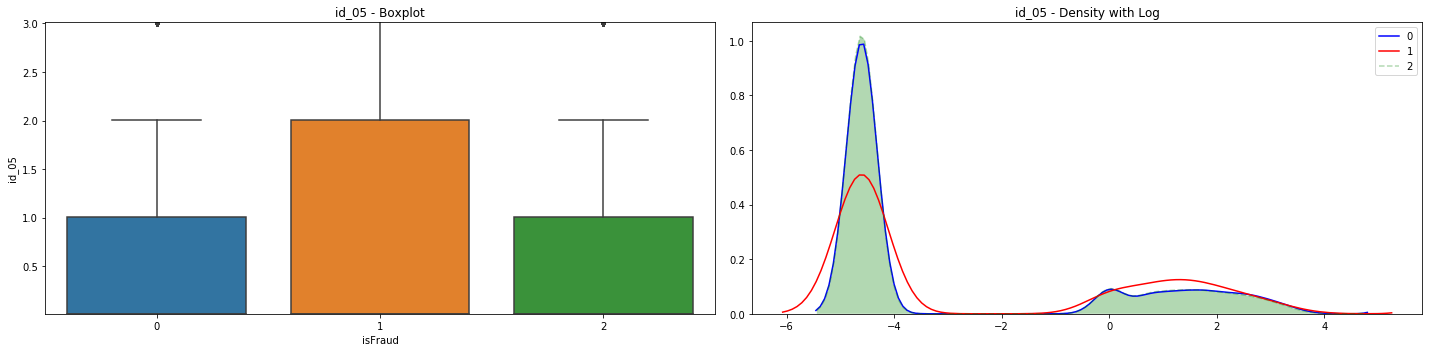

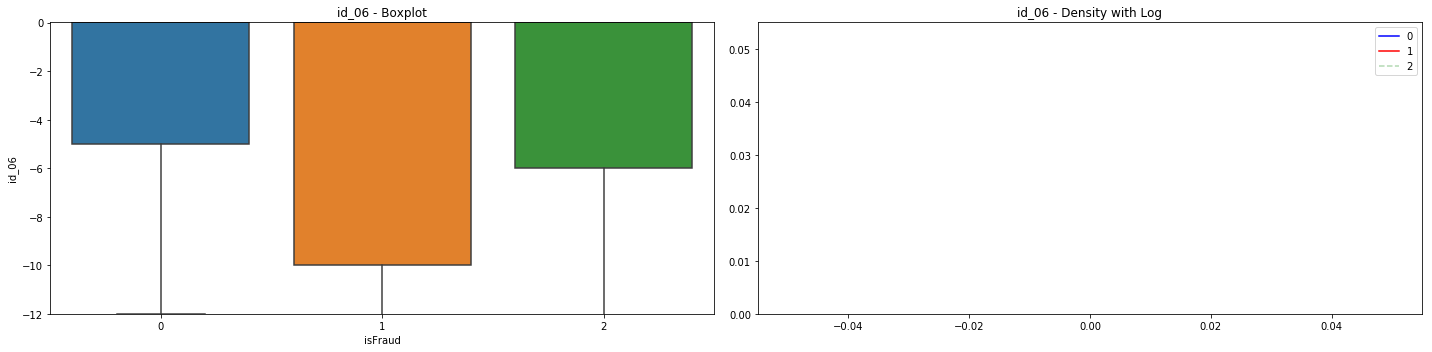

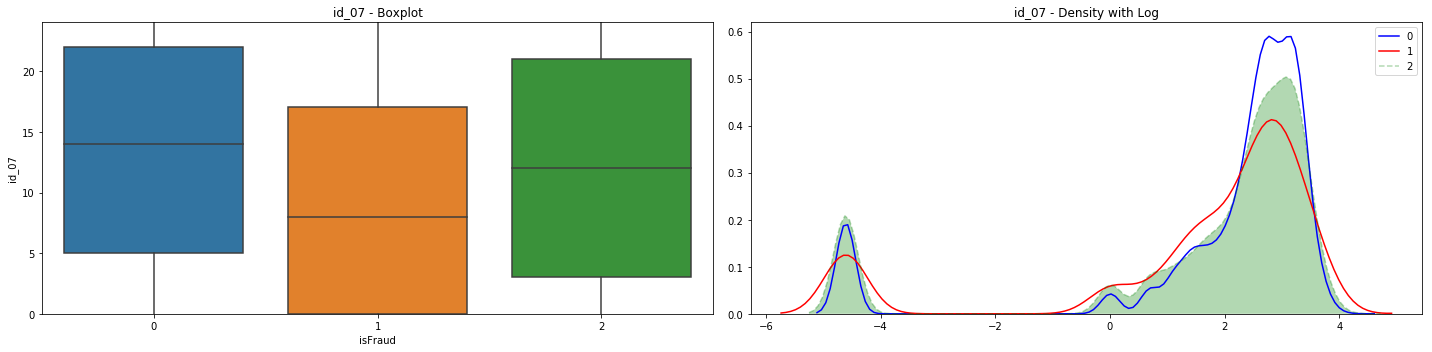

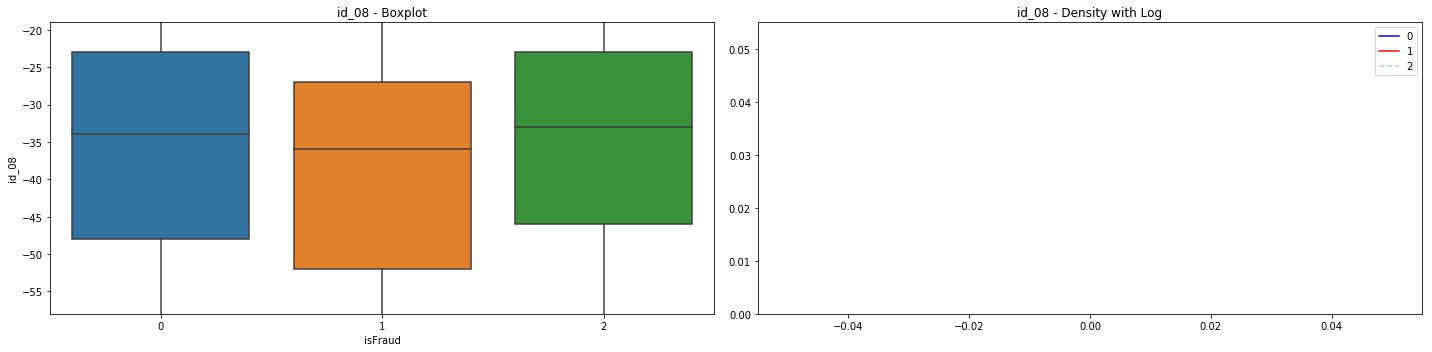

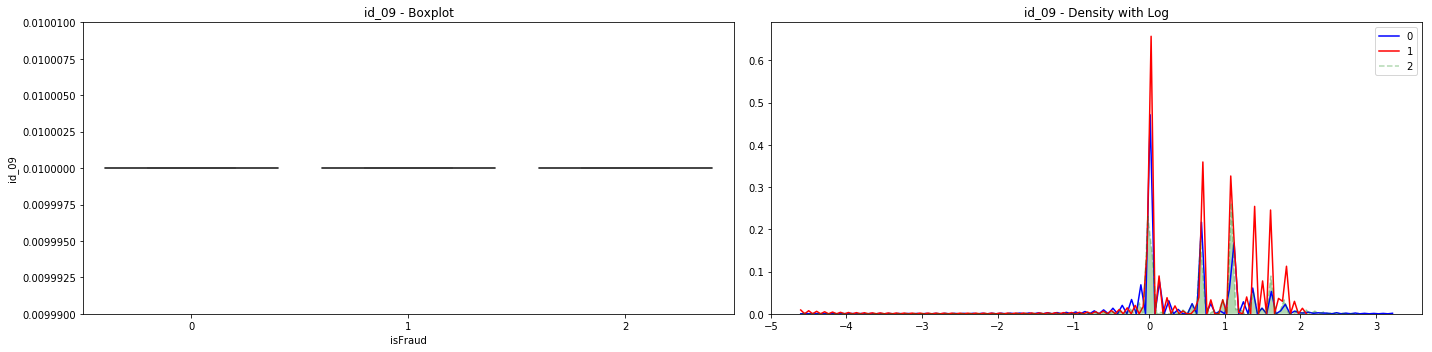

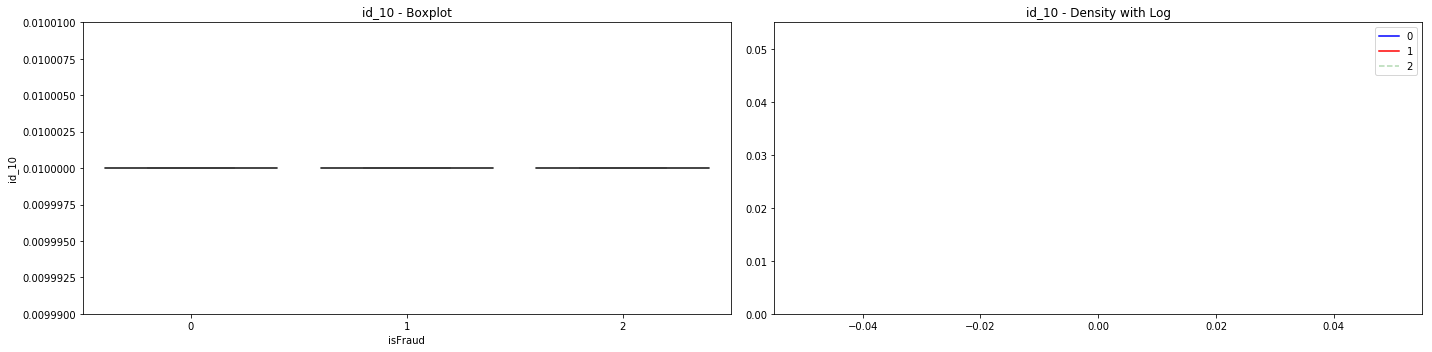

In [17]:
rm_list = ['TransactionID','TransactionDT','isFraud']
type_list = ['int64','float']
feature_list = []

for feature in identity.columns:
    if (feature not in rm_list) & (identity[feature].dtypes in type_list) & (len(identity[feature].unique()) > 10):

        feature_list.append(feature)
for feature in feature_list[:10]:
    eda_numeric(identity,feature)

It's kinda messy now, don't worry it helps us to have a general overview about the distributions according Fraud/not Fraud types, I will have a compact version soon